In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# plt.rcParams['figure.figsize'] = [8.0, 8.0]
%config InlineBackend.figure_formats = ['retina']
plt.rcParams['figure.dpi'] = 140
plt.rcParams['savefig.dpi'] = 300

# Display settings: 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

# Update the default parameters for Matplotlib plots to specify various aspects of the plot's appearance,
# including the figure size, colors, gridlines, fonts, and more
plt.rcParams.update({
    # Overall Figure Aesthetics
    'figure.figsize': (8, 5),
    'figure.facecolor': 'white',

    # Axes and Grid
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.grid.which': 'major',
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,

    # Spines (Borders)
    'axes.spines.top': False,
    'axes.spines.right': False,

    # Ticks and Tick Labels
    'xtick.bottom': True,
    'xtick.major.size': 3,
    'xtick.minor.size': 0,
    'ytick.left': True,
    'ytick.major.size': 3,
    'ytick.minor.size': 0,

    # Fonts and Text
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans', 'Lucida Grande', 'Verdana'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,

    # Lines and Markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Colors
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'axes.titlecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
})

In [2]:
!pip install xgboost

In [3]:
import importlib
import ts_utils
importlib.reload(ts_utils)


<module 'ts_utils' from '/Users/emillianlandu/Emillia_Nlandu_Capstone_Sprint1/notebooks/ts_utils.py'>

In [4]:
from ts_utils import load_and_clean_traffic_data


In [5]:
def load_and_clean_traffic_data(path):
    """
    This function loads the traffic dataset,
    drops unnecessary columns, converts the 'count_date' to datetime,
    and returns the cleaned dataframe.

    Args:
        path (str): Absolute path to data file (csv)

    Returns:
        df (DataFrame): Cleaned Pandas DataFrame
    """
    df = pd.read_csv(path)
    
    # Drop unnecessary columns
    columns_to_drop = ['count_point_id', 'region_id', 'region_ons_code', 
                        'local_authority_code', 'easting', 
                       'northing', 'latitude', 'longitude']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=False)
    
    # Convert 'count_date' to datetime
    df['count_date'] = pd.to_datetime(df['count_date'])
    
    # Optionally rename columns for consistency
    df.columns = df.columns.str.lower()
    
    return df

In [6]:
# Standard Library
import itertools
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statsmodels
from statsmodels.api import tsa
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# scikit-learn
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prophet
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# XGboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree


# Utils
# from ts_utils import load_and_clean_air_traffic, \
#     plot_rolling_mean_and_std, \
#     lag_plots, \
#     decompose_series, \
#     perform_adf_test, \
#     perform_kpss_test

In [7]:
plt.rcParams["figure.figsize"] = (9,6)

In [8]:
# import pandas as pd

# # Load the first dataset (Traffic Data)
# east_of_england_data = load_and_clean_traffic_data('/Users/emillianlandu/Emillia_Nlandu_Capstone_Sprint1/data/east_of_england_data.csv')

# # Load the second dataset (Matching Localities)
# matching_localities = pd.read_csv('/Users/emillianlandu/Emillia_Nlandu_Capstone_Sprint1/data/matching_localities_east_of_england.csv')



In [9]:
east_of_england_data = pd.read_csv('/Users/emillianlandu/Emillia_Nlandu_Capstone_Sprint1/data/east_of_england_data.csv')

matching_localities = pd.read_csv('/Users/emillianlandu/Emillia_Nlandu_Capstone_Sprint1/data/matching_localities_east_of_england.csv')

In [10]:
east_of_england_data.head()

,count_point_id,direction_of_travel,year,count_date,hour,region_id,region_name,region_ons_code,local_authority_id,local_authority_name,local_authority_code,road_name,road_category,road_type,easting,northing,latitude,longitude,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,all_HGVs,all_motor_vehicles,Month,Day_of_Week,Day
0,6003,N,2000,2000-03-31,7,7,East of England,E12000006,208,Bedfordshire,E10000001,M1,TM,Major,500244,234300,51.998107,-0.54127,0,6,2804.0,5.0,513,171.0,40.0,36.0,63.0,223,145.0,678.0,4006.0,3,Friday,31
1,6003,N,2000,2000-03-31,8,7,East of England,E12000006,208,Bedfordshire,E10000001,M1,TM,Major,500244,234300,51.998107,-0.54127,0,5,3100.0,11.0,436,203.0,17.0,11.0,60.0,180,119.0,590.0,4142.0,3,Friday,31
2,6003,N,2000,2000-03-31,9,7,East of England,E12000006,208,Bedfordshire,E10000001,M1,TM,Major,500244,234300,51.998107,-0.54127,0,9,2235.0,28.0,372,226.0,24.0,17.0,85.0,212,117.0,681.0,3325.0,3,Friday,31
3,6003,N,2000,2000-03-31,10,7,East of England,E12000006,208,Bedfordshire,E10000001,M1,TM,Major,500244,234300,51.998107,-0.54127,0,9,2259.0,26.0,457,202.0,26.0,22.0,80.0,262,157.0,749.0,3500.0,3,Friday,31
4,6003,N,2000,2000-03-31,11,7,East of England,E12000006,208,Bedfordshire,E10000001,M1,TM,Major,500244,234300,51.998107,-0.54127,0,4,2428.0,41.0,492,220.0,24.0,17.0,77.0,218,172.0,728.0,3693.0,3,Friday,31


In [11]:
matching_localities.head()

,local_authority_id,local_authority_name,local_authority_code,year,link_length_km,link_length_miles,cars_and_taxis,all_motor_vehicles
0,78,Hertfordshire,E10000015,1993,5084.74,3159.51,4.942400e+09,5.976800e+09
1,97,Cambridgeshire,E10000003,1993,4548.66,2826.41,2.793000e+09,3.524200e+09
2,120,Luton,E06000032,1993,436.30,271.10,3.724000e+08,4.404000e+08
3,123,Essex,E10000012,1993,7795.80,4844.09,5.746500e+09,7.011500e+09
4,126,Suffolk,E10000029,1993,6756.78,4198.47,2.425100e+09,3.037600e+09


In [12]:
matching_localities.shape

(325, 8)

In [13]:
matching_localities.columns

Index(['local_authority_id', 'local_authority_name', 'local_authority_code',
       'year', 'link_length_km', 'link_length_miles', 'cars_and_taxis',
       'all_motor_vehicles'],
      dtype='object')

In [14]:
east_of_england_data.shape

(550056, 34)

In [15]:
east_of_england_data.columns

Index(['count_point_id', 'direction_of_travel', 'year', 'count_date', 'hour',
       'region_id', 'region_name', 'region_ons_code', 'local_authority_id',
       'local_authority_name', 'local_authority_code', 'road_name',
       'road_category', 'road_type', 'easting', 'northing', 'latitude',
       'longitude', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'LGVs', 'HGVs_2_rigid_axle',
       'HGVs_3_rigid_axle', 'HGVs_4_or_more_rigid_axle',
       'HGVs_3_or_4_articulated_axle', 'HGVs_5_articulated_axle',
       'HGVs_6_articulated_axle', 'all_HGVs', 'all_motor_vehicles', 'Month',
       'Day_of_Week', 'Day'],
      dtype='object')

## Data Cleaning

In [16]:
import pandas as pd

# Convert 'count_date' to datetime
east_of_england_data['count_date'] = pd.to_datetime(east_of_england_data['count_date'])

# Check the data types to ensure proper formatting
print(east_of_england_data.dtypes)

# Drop unnecessary columns (modify as per your requirement)
columns_to_drop = ['count_point_id', 'direction_of_travel', 'region_id', 'region_ons_code', 
                   'local_authority_code', 'road_name', 'easting', 'northing', 'latitude', 'longitude']
east_of_england_data = east_of_england_data.drop(columns=columns_to_drop)

# Preview the cleaned data
print(east_of_england_data.head())


count_point_id                           int64
direction_of_travel                     object
year                                     int64
count_date                      datetime64[ns]
hour                                     int64
region_id                                int64
region_name                             object
region_ons_code                         object
local_authority_id                       int64
local_authority_name                    object
local_authority_code                    object
road_name                               object
road_category                           object
road_type                               object
easting                                  int64
northing                                 int64
latitude                               float64
longitude                              float64
pedal_cycles                             int64
two_wheeled_motor_vehicles               int64
cars_and_taxis                         float64
buses_and_coa

In [17]:

# Check the data types to ensure proper formatting
print(matching_localities.dtypes)

# Drop unnecessary columns if needed (modify based on your needs)
# Assuming we might keep all columns for now as they are useful for merging

print(matching_localities.head())


local_authority_id        int64
local_authority_name     object
local_authority_code     object
year                      int64
link_length_km          float64
link_length_miles       float64
cars_and_taxis          float64
all_motor_vehicles      float64
dtype: object
   local_authority_id local_authority_name local_authority_code  year  \
0                  78        Hertfordshire            E10000015  1993   
1                  97       Cambridgeshire            E10000003  1993   
2                 120                Luton            E06000032  1993   
3                 123                Essex            E10000012  1993   
4                 126              Suffolk            E10000029  1993   

   link_length_km  link_length_miles  cars_and_taxis  all_motor_vehicles  
0         5084.74            3159.51    4.942400e+09        5.976800e+09  
1         4548.66            2826.41    2.793000e+09        3.524200e+09  
2          436.30             271.10    3.724000e+08        4.4040

In [18]:
# Ensure 'local_authority_id' is the same type in both datasets (convert to string)
east_of_england_data['local_authority_id'] = east_of_england_data['local_authority_id'].astype(str)
matching_localities['local_authority_id'] = matching_localities['local_authority_id'].astype(str)

# Merge the datasets on 'local_authority_id' and 'year'
merged_data = pd.merge(east_of_england_data, matching_localities, on=['local_authority_id', 'year'], how='inner')

# Check the merged dataset
merged_data.head()


,year,count_date,hour,region_name,local_authority_id,local_authority_name_x,road_category,road_type,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis_x,buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,all_HGVs,all_motor_vehicles_x,Month,Day_of_Week,Day,local_authority_name_y,local_authority_code,link_length_km,link_length_miles,cars_and_taxis_y,all_motor_vehicles_y
0,2000,2000-03-31,7,East of England,208,Bedfordshire,TM,Major,0,6,2804.0,5.0,513,171.0,40.0,36.0,63.0,223,145.0,678.0,4006.0,3,Friday,31,Bedfordshire,E10000001,2311.17,1436.09,1.854200e+09,2.348900e+09
1,2000,2000-03-31,8,East of England,208,Bedfordshire,TM,Major,0,5,3100.0,11.0,436,203.0,17.0,11.0,60.0,180,119.0,590.0,4142.0,3,Friday,31,Bedfordshire,E10000001,2311.17,1436.09,1.854200e+09,2.348900e+09
2,2000,2000-03-31,9,East of England,208,Bedfordshire,TM,Major,0,9,2235.0,28.0,372,226.0,24.0,17.0,85.0,212,117.0,681.0,3325.0,3,Friday,31,Bedfordshire,E10000001,2311.17,1436.09,1.854200e+09,2.348900e+09
3,2000,2000-03-31,10,East of England,208,Bedfordshire,TM,Major,0,9,2259.0,26.0,457,202.0,26.0,22.0,80.0,262,157.0,749.0,3500.0,3,Friday,31,Bedfordshire,E10000001,2311.17,1436.09,1.854200e+09,2.348900e+09
4,2000,2000-03-31,11,East of England,208,Bedfordshire,TM,Major,0,4,2428.0,41.0,492,220.0,24.0,17.0,77.0,218,172.0,728.0,3693.0,3,Friday,31,Bedfordshire,E10000001,2311.17,1436.09,1.854200e+09,2.348900e+09


In [19]:
merged_data.shape

(549312, 30)

In [20]:
merged_data['all_motor_vehicles_x'].head()

0    4006.0
1    4142.0
2    3325.0
3    3500.0
4    3693.0
Name: all_motor_vehicles_x, dtype: float64

In [21]:
merged_data['all_motor_vehicles_y'].head()

0    2.348900e+09
1    2.348900e+09
2    2.348900e+09
3    2.348900e+09
4    2.348900e+09
Name: all_motor_vehicles_y, dtype: float64

### Check Redundancies Columns

In [33]:
# Drop redundant columns (from matching_localities) if not needed
merged_data = merged_data.drop(columns=['cars_and_taxis_y', 'all_motor_vehicles_y', 'local_authority_name_y', 'region_name'])

# Inspect the remaining columns
merged_data.columns


KeyError: "['cars_and_taxis_y', 'all_motor_vehicles_y', 'local_authority_name_y'] not found in axis"

### Aggregate the Data to Daily Totals

In [30]:
# Ensure 'count_date' is in datetime format
merged_data['count_date'] = pd.to_datetime(merged_data['count_date'])

# Aggregate the data by date (sum vehicle counts for each day)
daily_data = merged_data.groupby('count_date').sum().reset_index()

# Inspect the aggregated daily data
daily_data[['count_date', 'cars_and_taxis_x', 'all_motor_vehicles_x']].head()


,count_date,cars_and_taxis_x,all_motor_vehicles_x
0,2000-03-17,79773.0,98167.0
1,2000-03-20,141798.0,181149.0
2,2000-03-21,111629.0,145448.0
3,2000-03-22,96640.0,124106.0
4,2000-03-23,101604.0,128779.0


In [32]:
daily_data.head()

,count_date,year,hour,region_name,local_authority_id,local_authority_name_x,road_category,road_type,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis_x,buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,all_HGVs,all_motor_vehicles_x,Month,Day_of_Week,Day,local_authority_code,link_length_km,link_length_miles
0,2000-03-17,360000,2250,East of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandE...,208208208208208208208208208208208208787878787878787878787878787878787878787878787878979797979797979797979797979797979797979797979797120120120120120120120120120120120120120120120120120120120120120120120120123123123123123123123123123123123123123123123123123123123123123123123123126126126126126126126126126126126126126126126126126126126126126126126126154154154154154154154154154154154154154154154154154154154154154154154154129129129129129129129129129129129129129129129129129129129129129129129129,BedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireCambridgeshireCambridgeshireCambridgeshi...,MCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUTATATATATATATATATATATATATATATATATATATATATATATATAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCU,MinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorM...,1272,1218,79773.0,953.0,11423,2772.0,306.0,412.0,442.0,614,254.0,4800.0,98167.0,540,FridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFrid...,3060,E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E...,889219.56,552535.32
1,2000-03-20,528000,3300,Ea

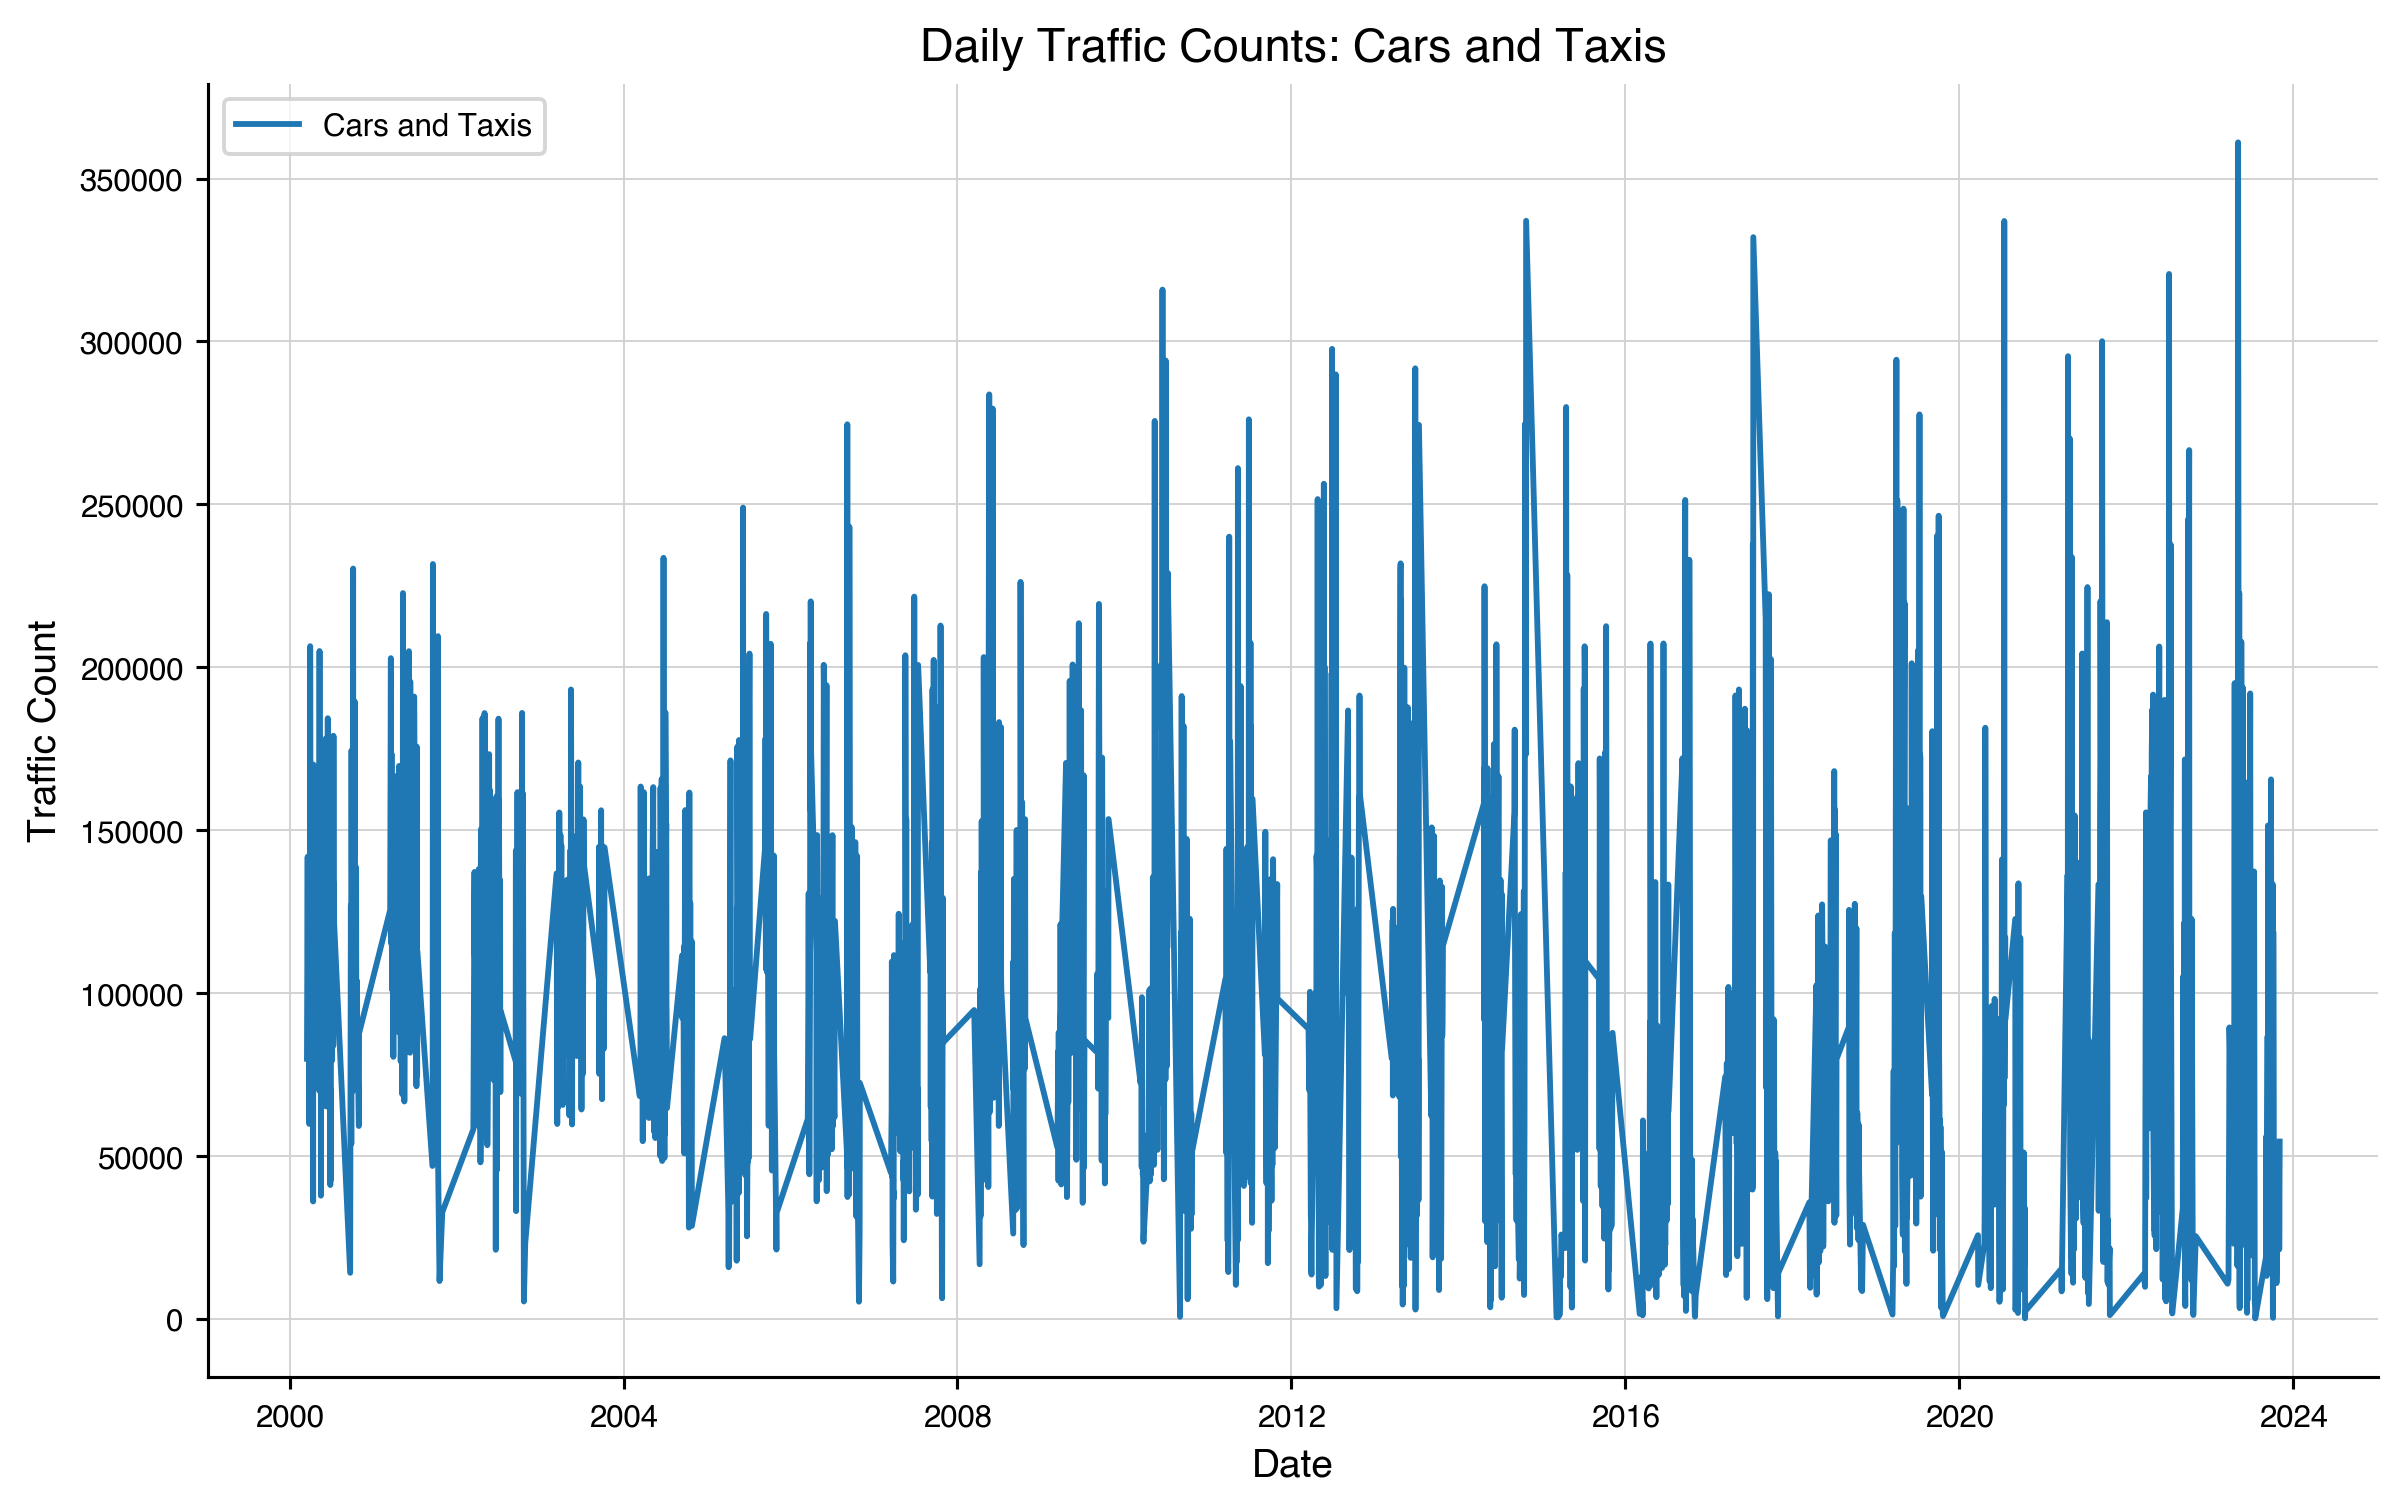

In [20]:
import matplotlib.pyplot as plt

# Plot the time series for 'cars_and_taxis_x'
plt.figure(figsize=(10, 6))
plt.plot(daily_data['count_date'], daily_data['cars_and_taxis_x'], label='Cars and Taxis')
plt.title('Daily Traffic Counts: Cars and Taxis')
plt.xlabel('Date')
plt.ylabel('Traffic Count')
plt.legend()
plt.grid(True)
plt.show()


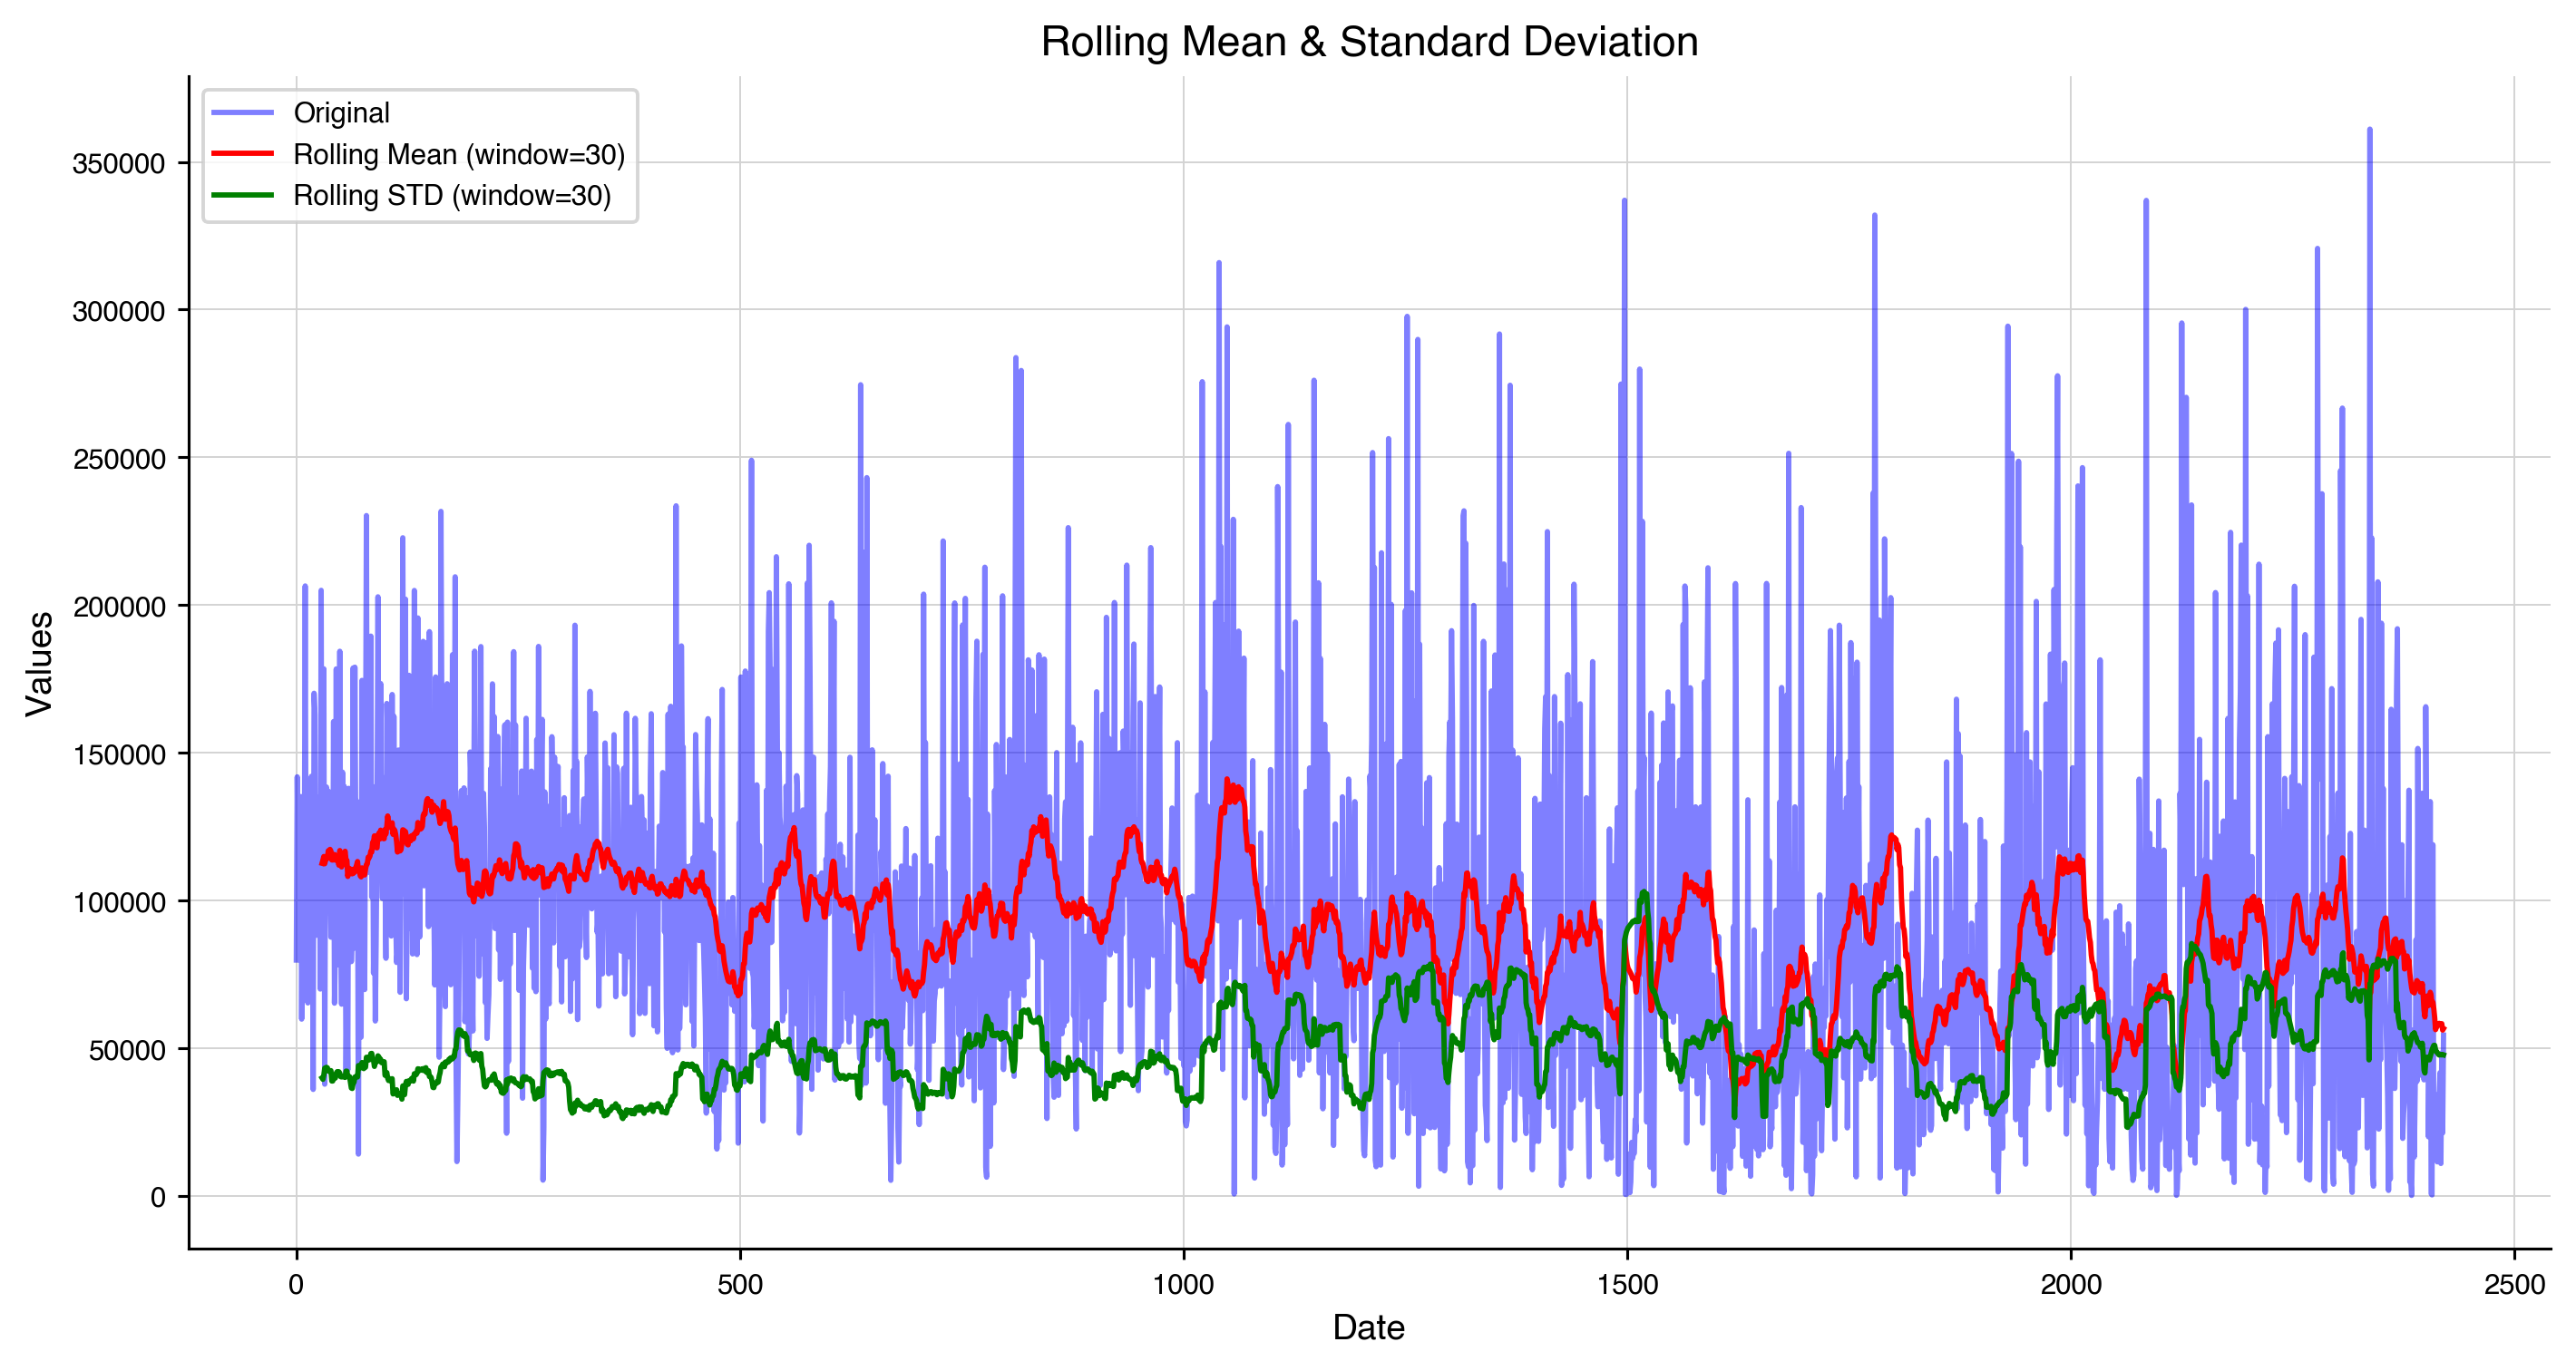

In [37]:
# Plot the rolling mean and standard deviation for the 'cars_and_taxis_x' time series
plot_rolling_mean_and_std(daily_data['cars_and_taxis_x'], window=30)  # e.g., 30-day window

### Aggregate Data to Yearly Level

In [25]:
# Aggregate data to yearly totals using the sum for each year
yearly_data = daily_data.resample('Y', on='count_date').sum()

# Convert the index to a "year" format for easier interpretation
yearly_data.index = yearly_data.index.year

# Check the yearly aggregated data
print(yearly_data[['cars_and_taxis_x', 'all_motor_vehicles_x']].head())


            cars_and_taxis_x  all_motor_vehicles_x
count_date                                        
2000              10346357.0            13568089.0
2001              11314989.0            14815110.0
2002              10555822.0            13772152.0
2003              10032472.0            12997545.0
2004              10398390.0            13501669.0


In [34]:
yearly_data['year']

count_date
2000    39096000
2001    41924952
2002    42858816
2003    45620328
2004    45787392
2005    41046360
2006    46121952
2007    42363756
2008    81131232
2009    67357752
2010    44887320
2011    41362248
2012    42541728
2013    40654548
2014    37677912
2015    38446200
2016    37715328
2017    43034712
2018    67707936
2019    70769988
2020    35535840
2021    39312492
2022    39307680
2023    32602668
Name: year, dtype: int64

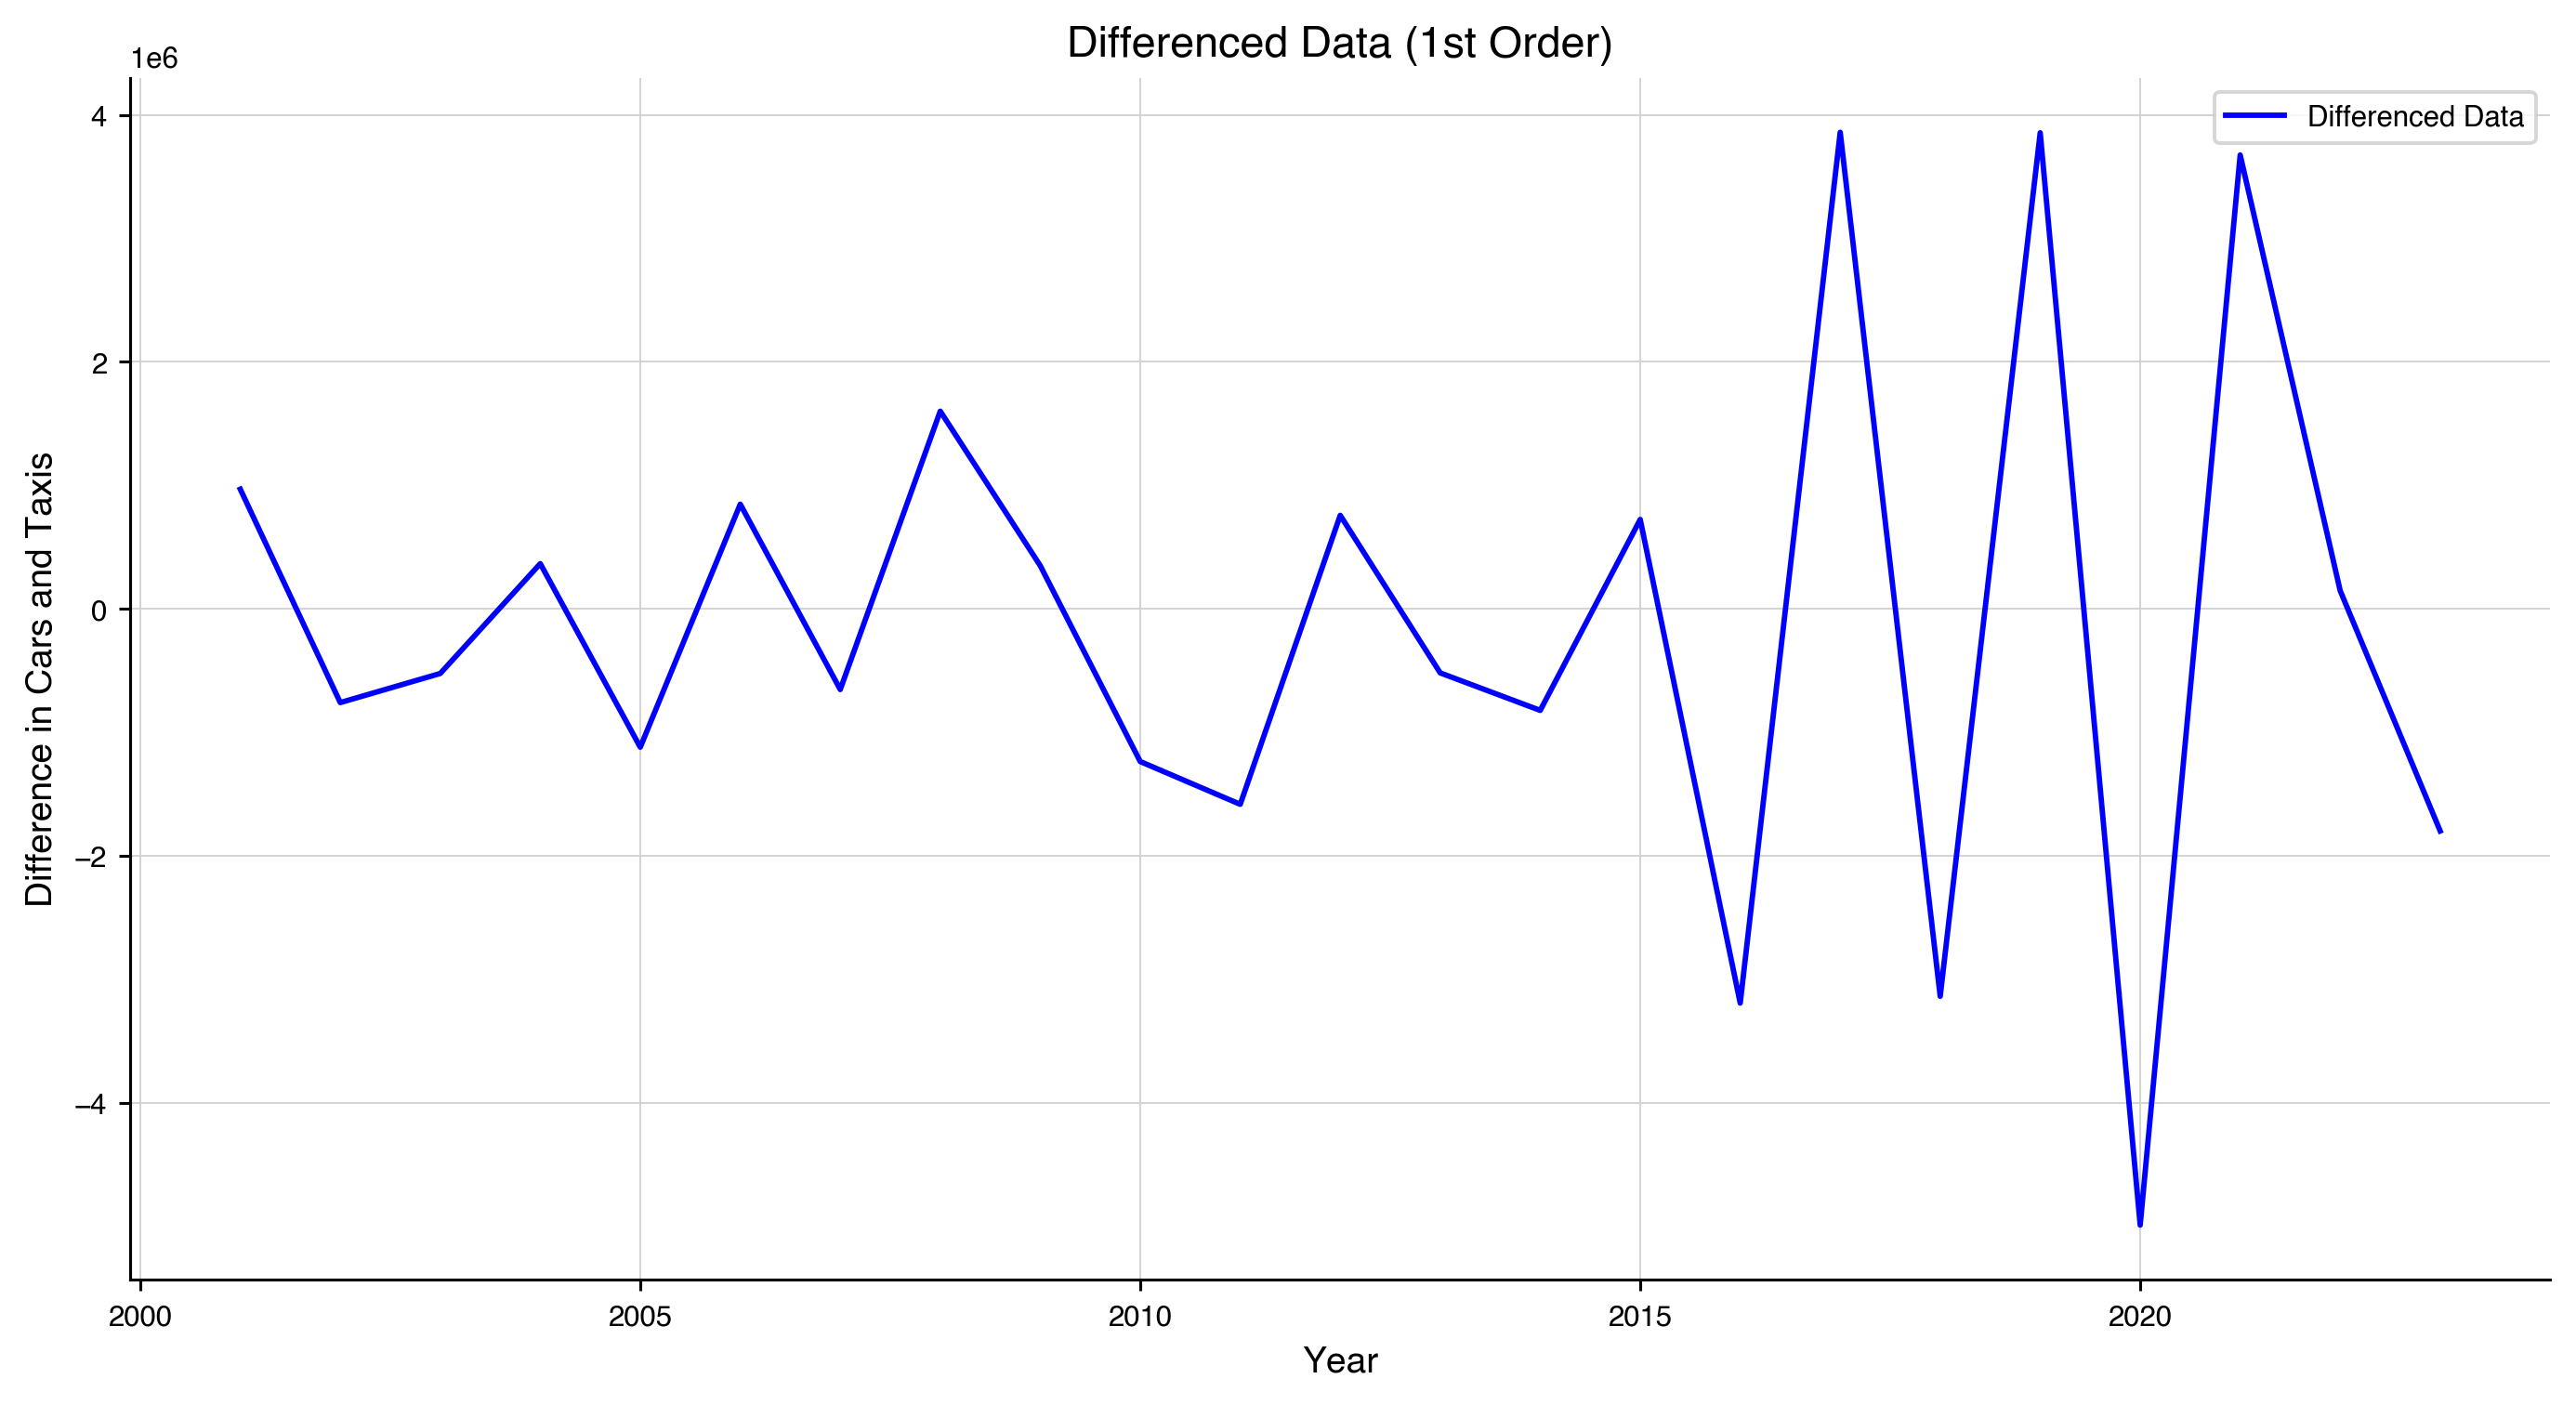

In [30]:
# Apply first-order differencing
diff_data = yearly_data['cars_and_taxis_x'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(diff_data, label='Differenced Data', color='blue')
plt.title('Differenced Data (1st Order)')
plt.xlabel('Year')
plt.ylabel('Difference in Cars and Taxis')
plt.legend()
plt.grid(True)
plt.show()


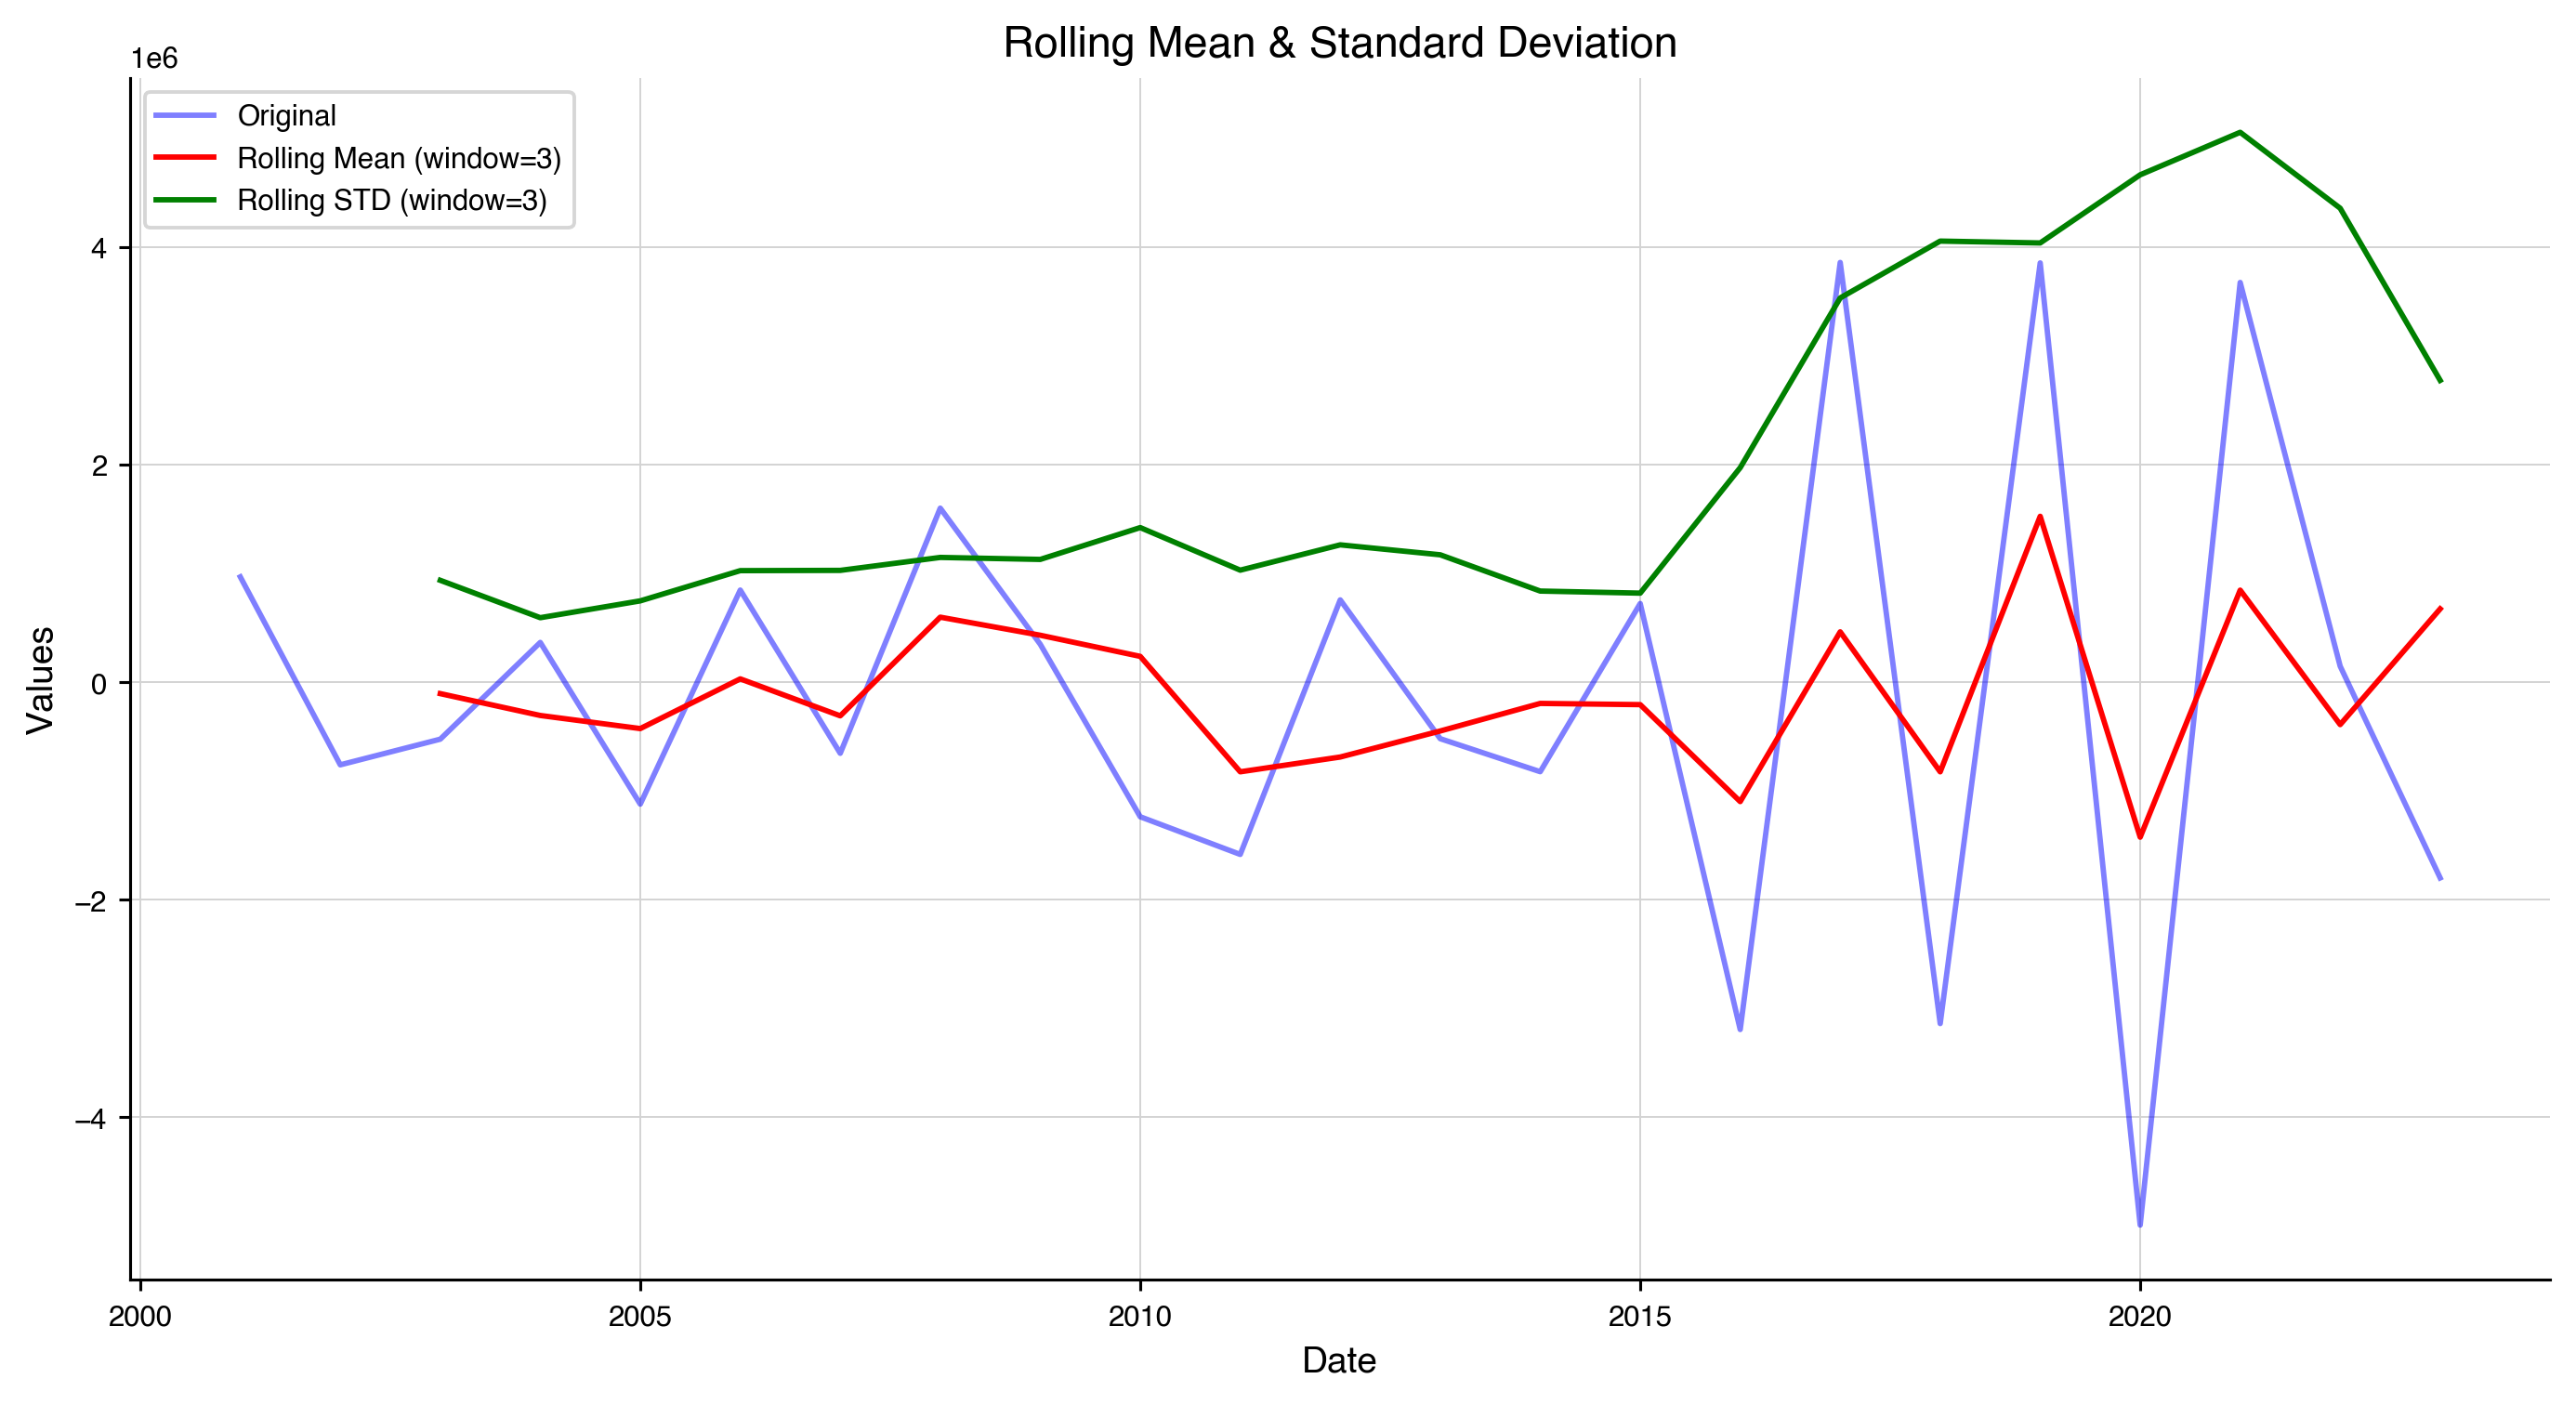

In [31]:
# Plot rolling mean and standard deviation after differencing
plot_rolling_mean_and_std(diff_data, window=3)


In [35]:
# Perform the Augmented Dickey-Fuller test on the differenced data
perform_adf_test(diff_data)


ADF Statistic: -1.822684
p-value: 0.369259
Critical Values:
   1%: -3.9644434814814815
   5%: -3.0849081481481484
   10%: -2.6818144444444445


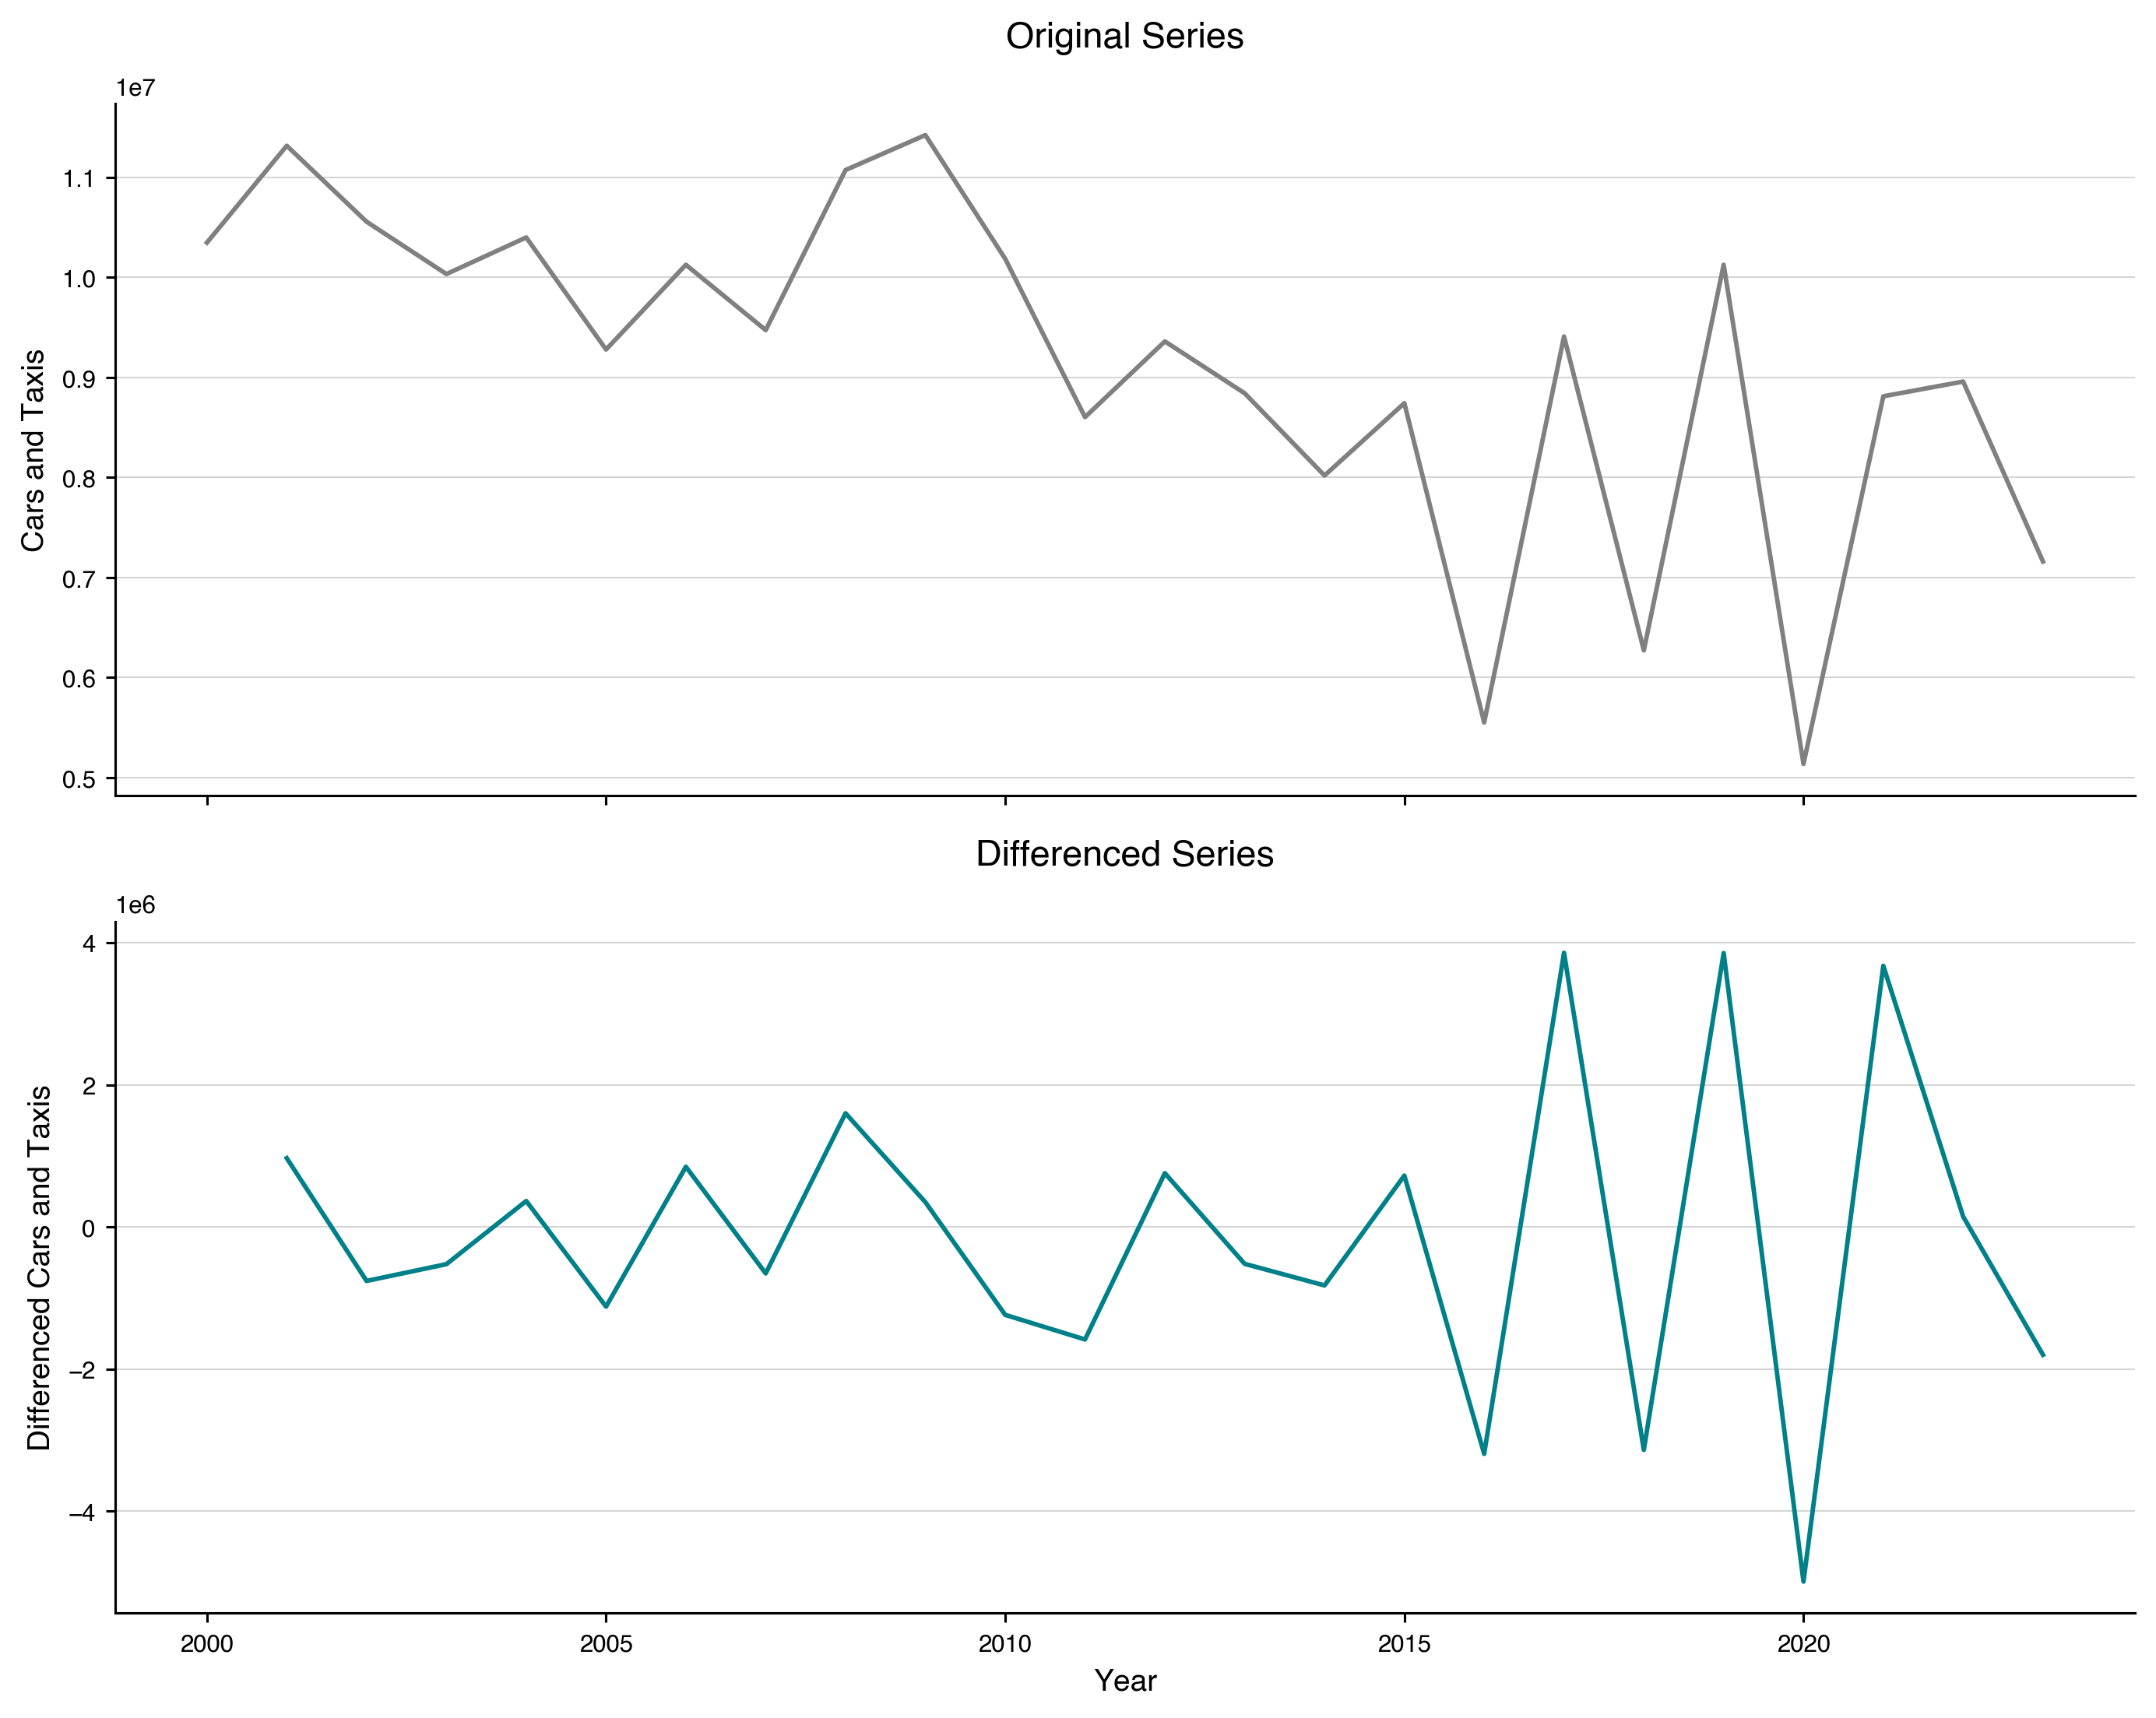

In [38]:
import matplotlib.pyplot as plt

# Plot the original and differenced series
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# Plot the original series
ax1.plot(yearly_data['cars_and_taxis_x'], color='#808080')
ax1.set_xlabel('')
ax1.set_ylabel('Cars and Taxis')
ax1.set_title('Original Series\n')

# Plot the differenced series
ax2.plot(diff_data, '#008088')
ax2.set_xlabel('Year')
ax2.set_ylabel('Differenced Cars and Taxis')
ax2.set_title('Differenced Series\n')

plt.tight_layout()
plt.show()


## Autocorrelation

In [39]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

def lag_plots(series: pd.Series, lags=[1, 12, 24]) -> None:
    """
    This function plots the lag correlation between 
    current y(t) and y(t-1), y(t-12), and y(t-24) lags (default) 
    or any custom lag provided.
    
    Args:
        series (pd.Series): The time series data (single column).
        lags (list): List of lag values for which to create lag plots.
    
    Returns:
        None
    """
    
    # Number of subplots based on the number of lags
    num_lags = len(lags)
    fig, axes = plt.subplots(1, num_lags, figsize=(16, 9), facecolor='w')
    
    # Loop over the lags to create lag plots for each specified lag
    for i, lag in enumerate(lags):
        lag_plot(series, lag=lag, ax=axes[i], c='#187bcd' if i % 2 == 0 else 'grey')
        axes[i].set_title(f"y(t+{lag})", fontsize=15, pad=10)
        axes[i].grid(linestyle=":", color='grey')
    
    
    plt.tight_layout()
    plt.show()


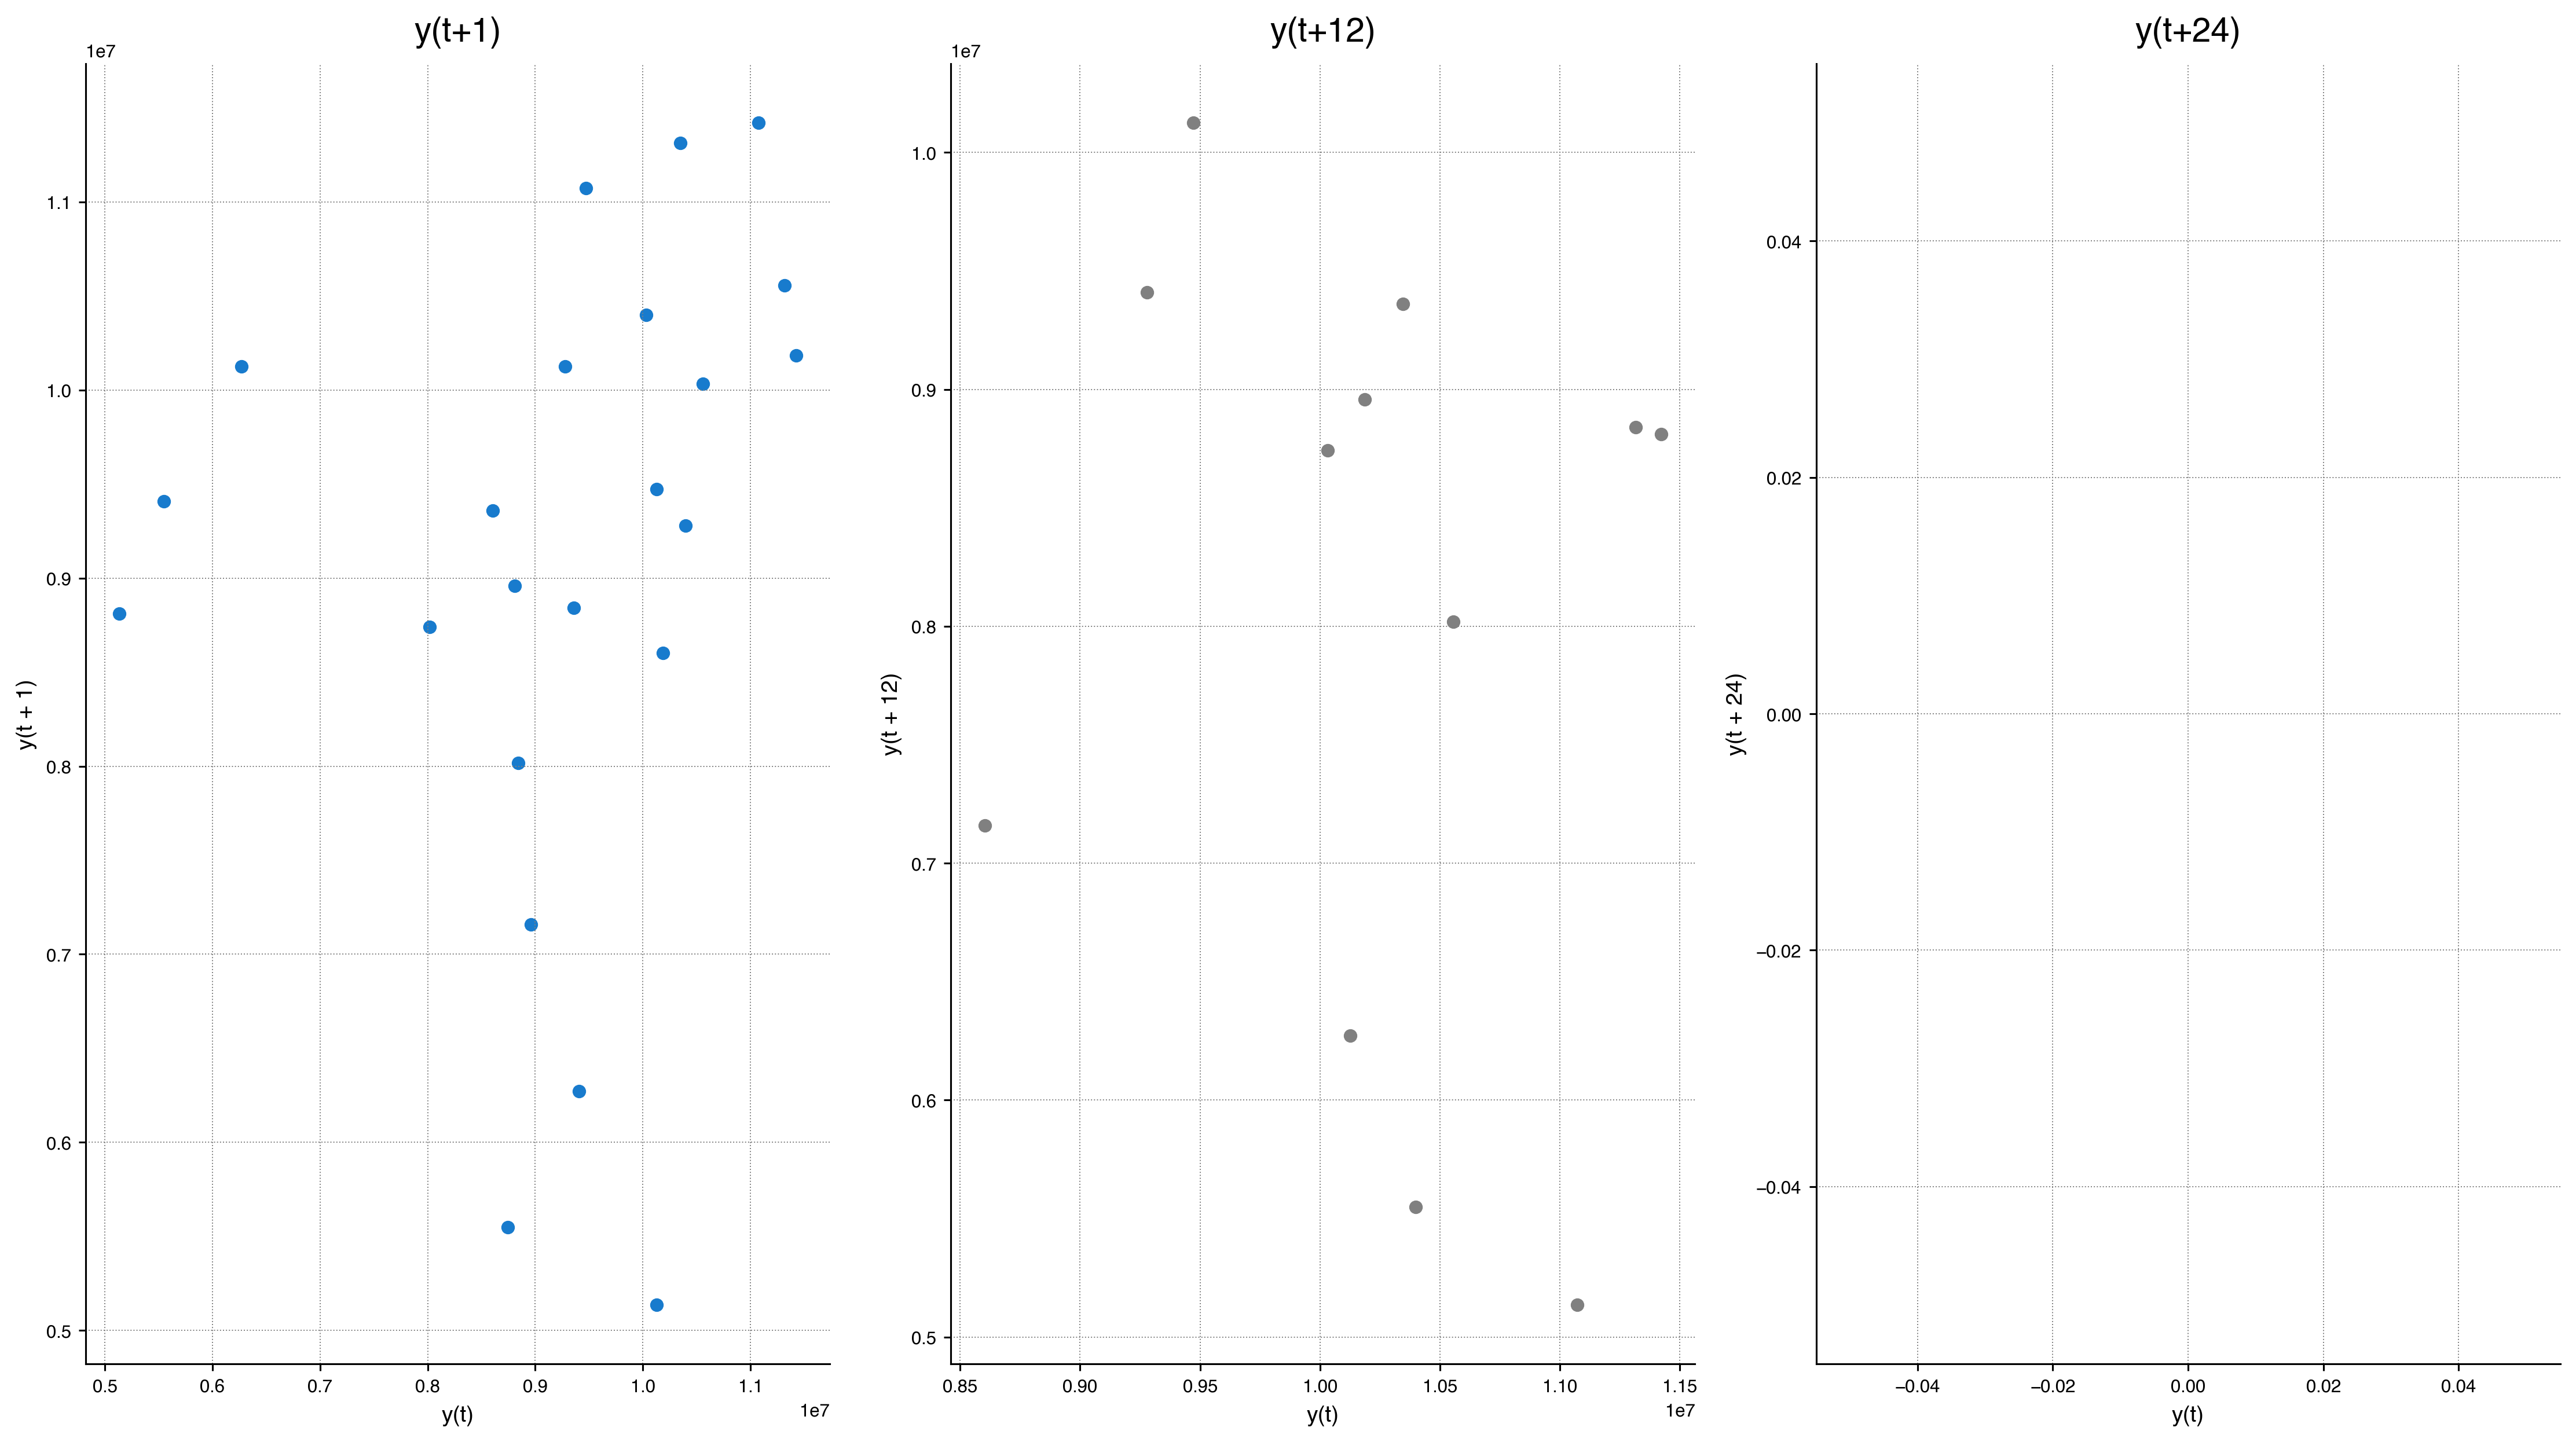

In [40]:
# Plot lag correlations for original series
lag_plots(yearly_data['cars_and_taxis_x'], lags=[1, 12, 24])  # Default lags


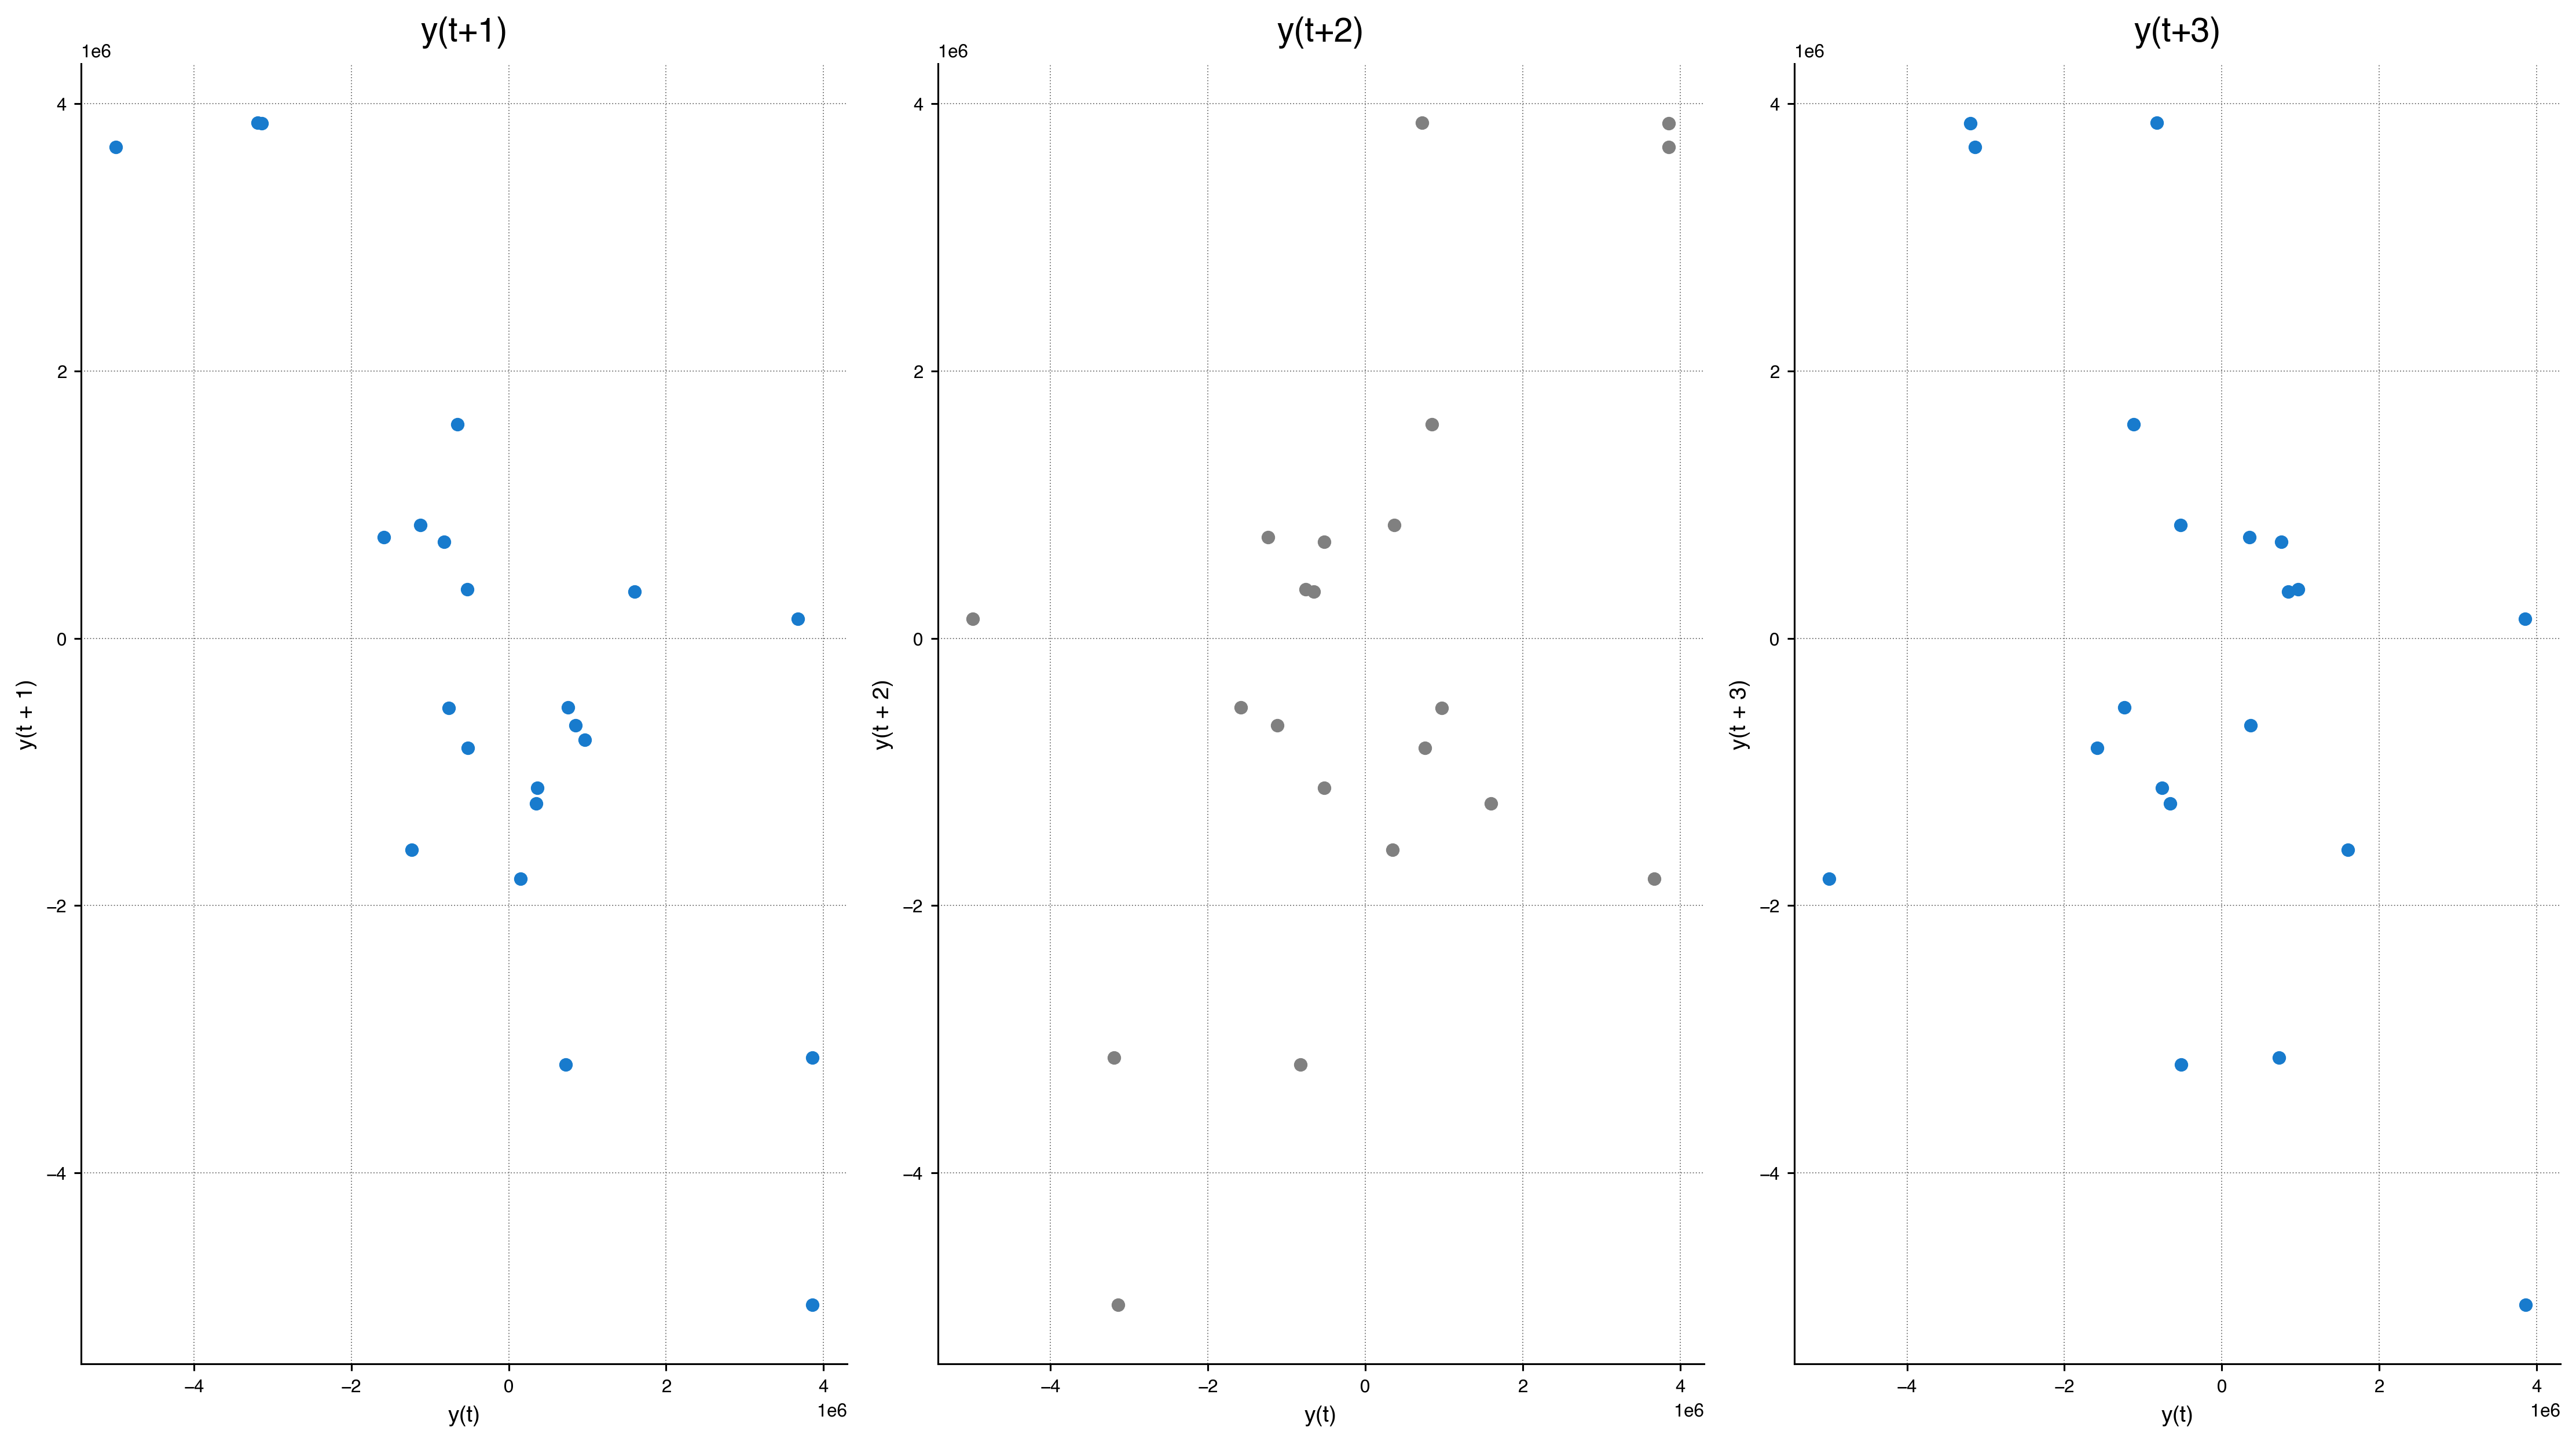

In [41]:
# Plot lag correlations for differenced series
lag_plots(diff_data, lags=[1, 2, 3])  # You can specify custom lags


### ACF and PACF Plots

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_pacf(series: pd.Series, lags: int) -> None:
    """
    Plots the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
    for a given time series.
    
    Args:
        series (pd.Series): The time series data.
        lags (int): Number of lags to compute ACF and PACF for.
        
    Returns:
        None
    """
    
    # Create a figure with two subplots: one for ACF and one for PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot ACF (Autocorrelation Function)
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)', fontsize=15)

    # Plot PACF (Partial Autocorrelation Function)
    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=15)

    plt.tight_layout()
    plt.show()


In [47]:
yearly_data.head(1)

,year,hour,region_name,local_authority_id,local_authority_name_x,road_category,road_type,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis_x,buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,all_HGVs,all_motor_vehicles_x,Month,Day_of_Week,Day,local_authority_code,link_length_km,link_length_miles
count_date,,,,,,,,,,,,,,,,,,,,,,,,,,
2000,39096000,244350,East of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandEast of EnglandE...,2082082082082082082082082082082082087878787878787878787878787878787878787878787878789797979797979797979797979797979797979797979797971201201201201201201201201201201201201201201201201201201201201201201201201231231231231231231231231231231231231231231231231231231231231231231231231261261261261261261261261261261261261261261261261261261261261261261261261541541541541541541541541541541541541541541541541541541541541541541541541291291291291291291291291291291291291291291291291291291291291291291291292082...,BedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireBedfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireHertfordshireCambridgeshireCambridgeshireCambridgeshi...,MCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUTATATATATATATATATATATATATATATATATATATATATATATATAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAPAMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUMCUTATATATATATATATATATATATATATATATATATATATATATATATAPAPAPAPAPAPAPAPAPAPAPAPAPAPA...,MinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMajorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorMinorM...,50756,107809,10346357.0,107209.0,1718423,494438.0,59749.0,68178.0,122451.0,326621,216854.0,1288291.0,13568089.0,121056,FridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFridayFrid...,293784,E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000001E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000015E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000003E10000

In [49]:
# Extracting the "cars_and_taxis_x" series from the data
cars_and_taxis_series = yearly_data['cars_and_taxis_x']

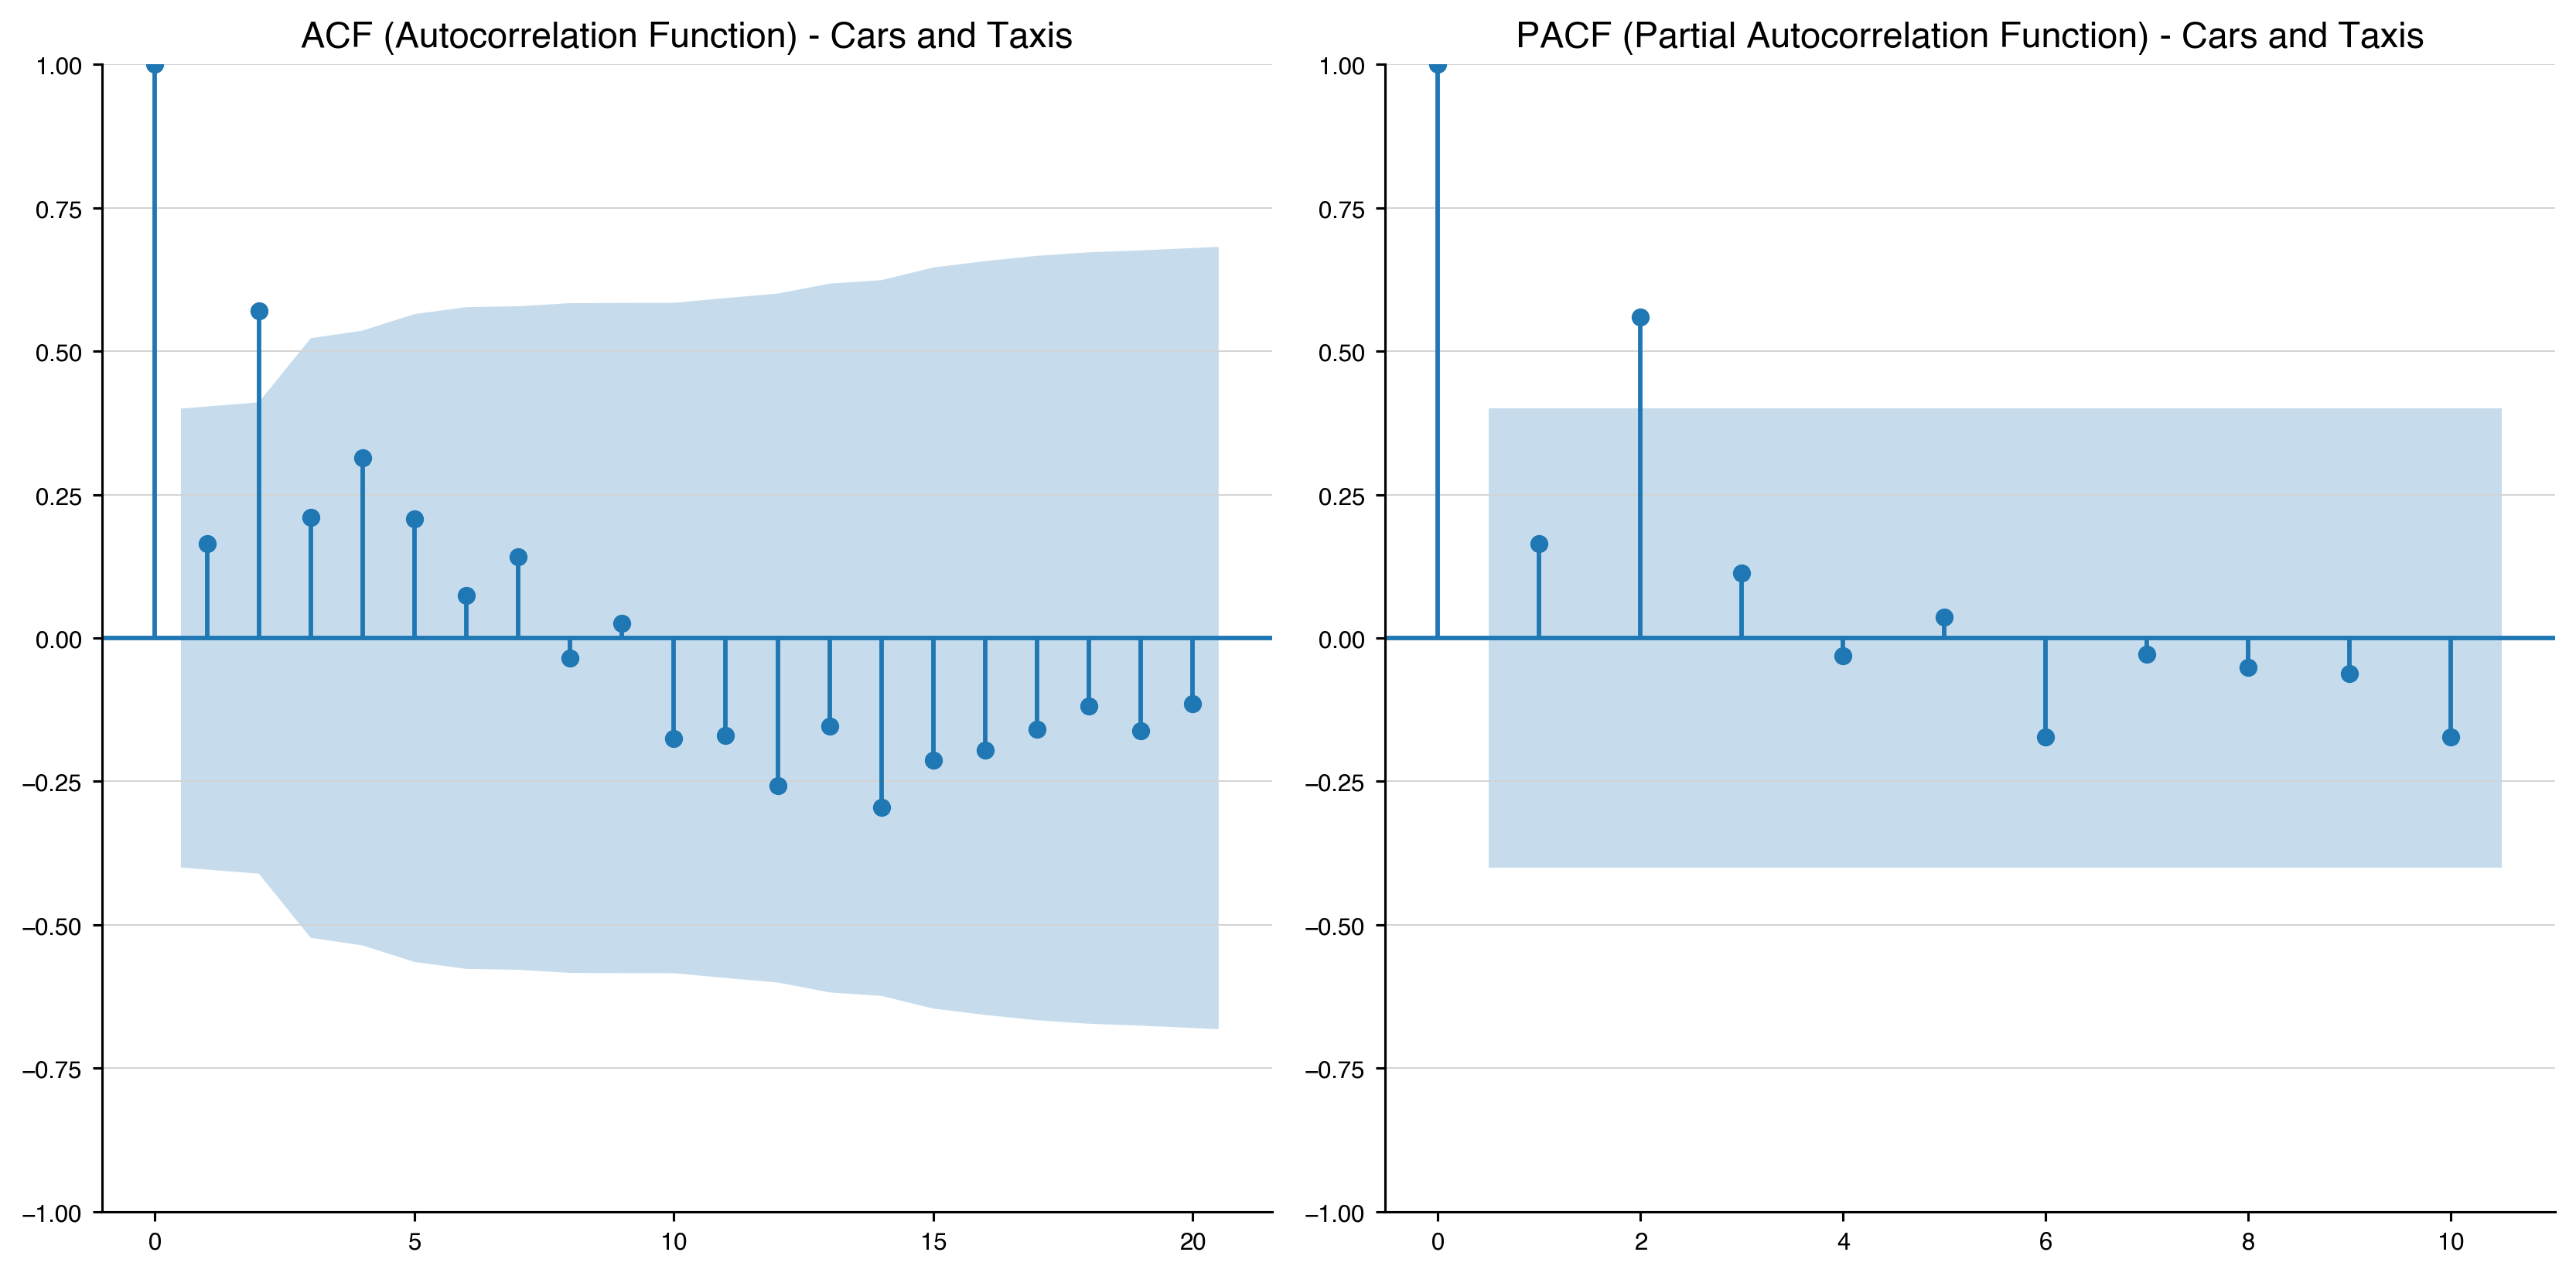

In [50]:
# Adjusting the lags to 10 for PACF due to data limitations
plt.figure(figsize=(12, 6))

# Autocorrelation Function (ACF) with 20 lags
plt.subplot(121)
plot_acf(cars_and_taxis_series, lags=20, ax=plt.gca())
plt.title("ACF (Autocorrelation Function) - Cars and Taxis")

# Partial Autocorrelation Function (PACF) with 10 lags
plt.subplot(122)
plot_pacf(cars_and_taxis_series, lags=10, ax=plt.gca())
plt.title("PACF (Partial Autocorrelation Function) - Cars and Taxis")

# Show the plots
plt.tight_layout()
plt.show()


### Decomposing the time series

In [59]:
yearly_data['year']

count_date
2000    39096000
2001    41924952
2002    42858816
2003    45620328
2004    45787392
2005    41046360
2006    46121952
2007    42363756
2008    81131232
2009    67357752
2010    44887320
2011    41362248
2012    42541728
2013    40654548
2014    37677912
2015    38446200
2016    37715328
2017    43034712
2018    67707936
2019    70769988
2020    35535840
2021    39312492
2022    39307680
2023    32602668
Name: year, dtype: int64

### Monthly and Quarterly Resampling

In [66]:
print(daily_data.columns)


Index(['year', 'hour', 'region_name', 'local_authority_id',
       'local_authority_name_x', 'road_category', 'road_type', 'pedal_cycles',
       'two_wheeled_motor_vehicles', 'cars_and_taxis_x', 'buses_and_coaches',
       'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle',
       'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle',
       'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'all_HGVs',
       'all_motor_vehicles_x', 'Month', 'Day_of_Week', 'Day',
       'local_authority_code', 'link_length_km', 'link_length_miles'],
      dtype='object')


In [79]:
import pandas as pd


# Ensure that the 'Month' and 'Day' columns are two digits (pad with zeroes if necessary)
daily_data['Month'] = daily_data['Month'].astype(str).str.zfill(2)
daily_data['Day'] = daily_data['Day'].astype(str).str.zfill(2)

# Combine 'year', 'Month', and 'Day' to create a 'count_date' column
daily_data['count_date'] = pd.to_datetime(daily_data['year'].astype(str) + 
                                          daily_data['Month'] + 
                                          daily_data['Day'], format='%Y%m%d')



invalid_rows = daily_data[daily_data['count_date'].isna()]

# Set 'count_date' as the index
daily_data.set_index('count_date', inplace=True)

# Now you can proceed with resampling


In [81]:
def decompose_series(df: pd.DataFrame, target_column: str) -> None:
    """
    This function decomposes the time series into trend, seasonality, and residuals.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        target_column (str): The name of the column to decompose

    Returns: None
    """
    # Manually create a 'year' datetime index based on the actual years
    years = pd.date_range(start='2000', periods=len(df), freq='Y')
    
    # Create a series with the 'years' as the index and the target column for decomposition
    series = pd.Series(df[target_column].values, index=years)

    # Decompose the series
    decomposition = seasonal_decompose(series, model='additive', period=1)  # Adjust `period` if needed
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotting the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), facecolor='w')

    ax1.plot(series, label='Original')
    ax2.plot(trend, label='Trend')
    ax3.plot(seasonal, label='Seasonality')
    ax4.plot(residual, label='Residuals')

    # Adding Legends
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')
    ax4.legend(loc='upper right')

    # Adding gridlines
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')
    ax3.grid(linestyle=":", color='grey')
    ax4.grid(linestyle=":", color='grey')

    # Title and layout
    plt.suptitle(f'Decomposed Time Series: {target_column}')
    plt.tight_layout()
    plt.show()


In [82]:
# Resample to monthly frequency
monthly_data = daily_data.resample('M').sum()

# Resample to quarterly frequency
quarterly_data = daily_data.resample('Q').sum()


In [86]:
print(monthly_data[['cars_and_taxis_x']].head(20))  # Inspect the first 20 rows of monthly data
print(monthly_data[['cars_and_taxis_x']].tail(20))  # Inspect the last 20 rows of monthly data


Empty DataFrame
Columns: [cars_and_taxis_x]
Index: []
Empty DataFrame
Columns: [cars_and_taxis_x]
Index: []


In [87]:
print(daily_data[['cars_and_taxis_x']].isnull().sum())  # Check for missing values
print(daily_data[['cars_and_taxis_x']].describe())  # Get basic statistics to check if the data is valid


cars_and_taxis_x    0.0
dtype: float64
       cars_and_taxis_x
count               0.0
mean                NaN
std                 NaN
min                 NaN
25%                 NaN
50%                 NaN
75%                 NaN
max                 NaN


In [88]:
print(yearly_data[['cars_and_taxis_x']].isnull().sum())  # Check for missing values
print(yearly_data[['cars_and_taxis_x']].describe())  # Get basic statistics to check if the data is valid


cars_and_taxis_x    0
dtype: int64
       cars_and_taxis_x
count      2.400000e+01
mean       9.132573e+06
std        1.691587e+06
min        5.135558e+06
25%        8.706971e+06
50%        9.383832e+06
75%        1.022545e+07
max        1.142168e+07


In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the monthly data
monthly_decomposition = seasonal_decompose(monthly_data['cars_and_taxis_x'], model='additive', period=12)
monthly_decomposition.plot()
plt.suptitle('Monthly Decomposition of Cars and Taxis')
plt.show()

# Decompose the quarterly data
quarterly_decomposition = seasonal_decompose(quarterly_data['cars_and_taxis_x'], model='additive', period=4)
quarterly_decomposition.plot()
plt.suptitle('Quarterly Decomposition of Cars and Taxis')
plt.show()


ValueError: x must have 2 complete cycles requires 24 observations. x only has 0 observation(s)

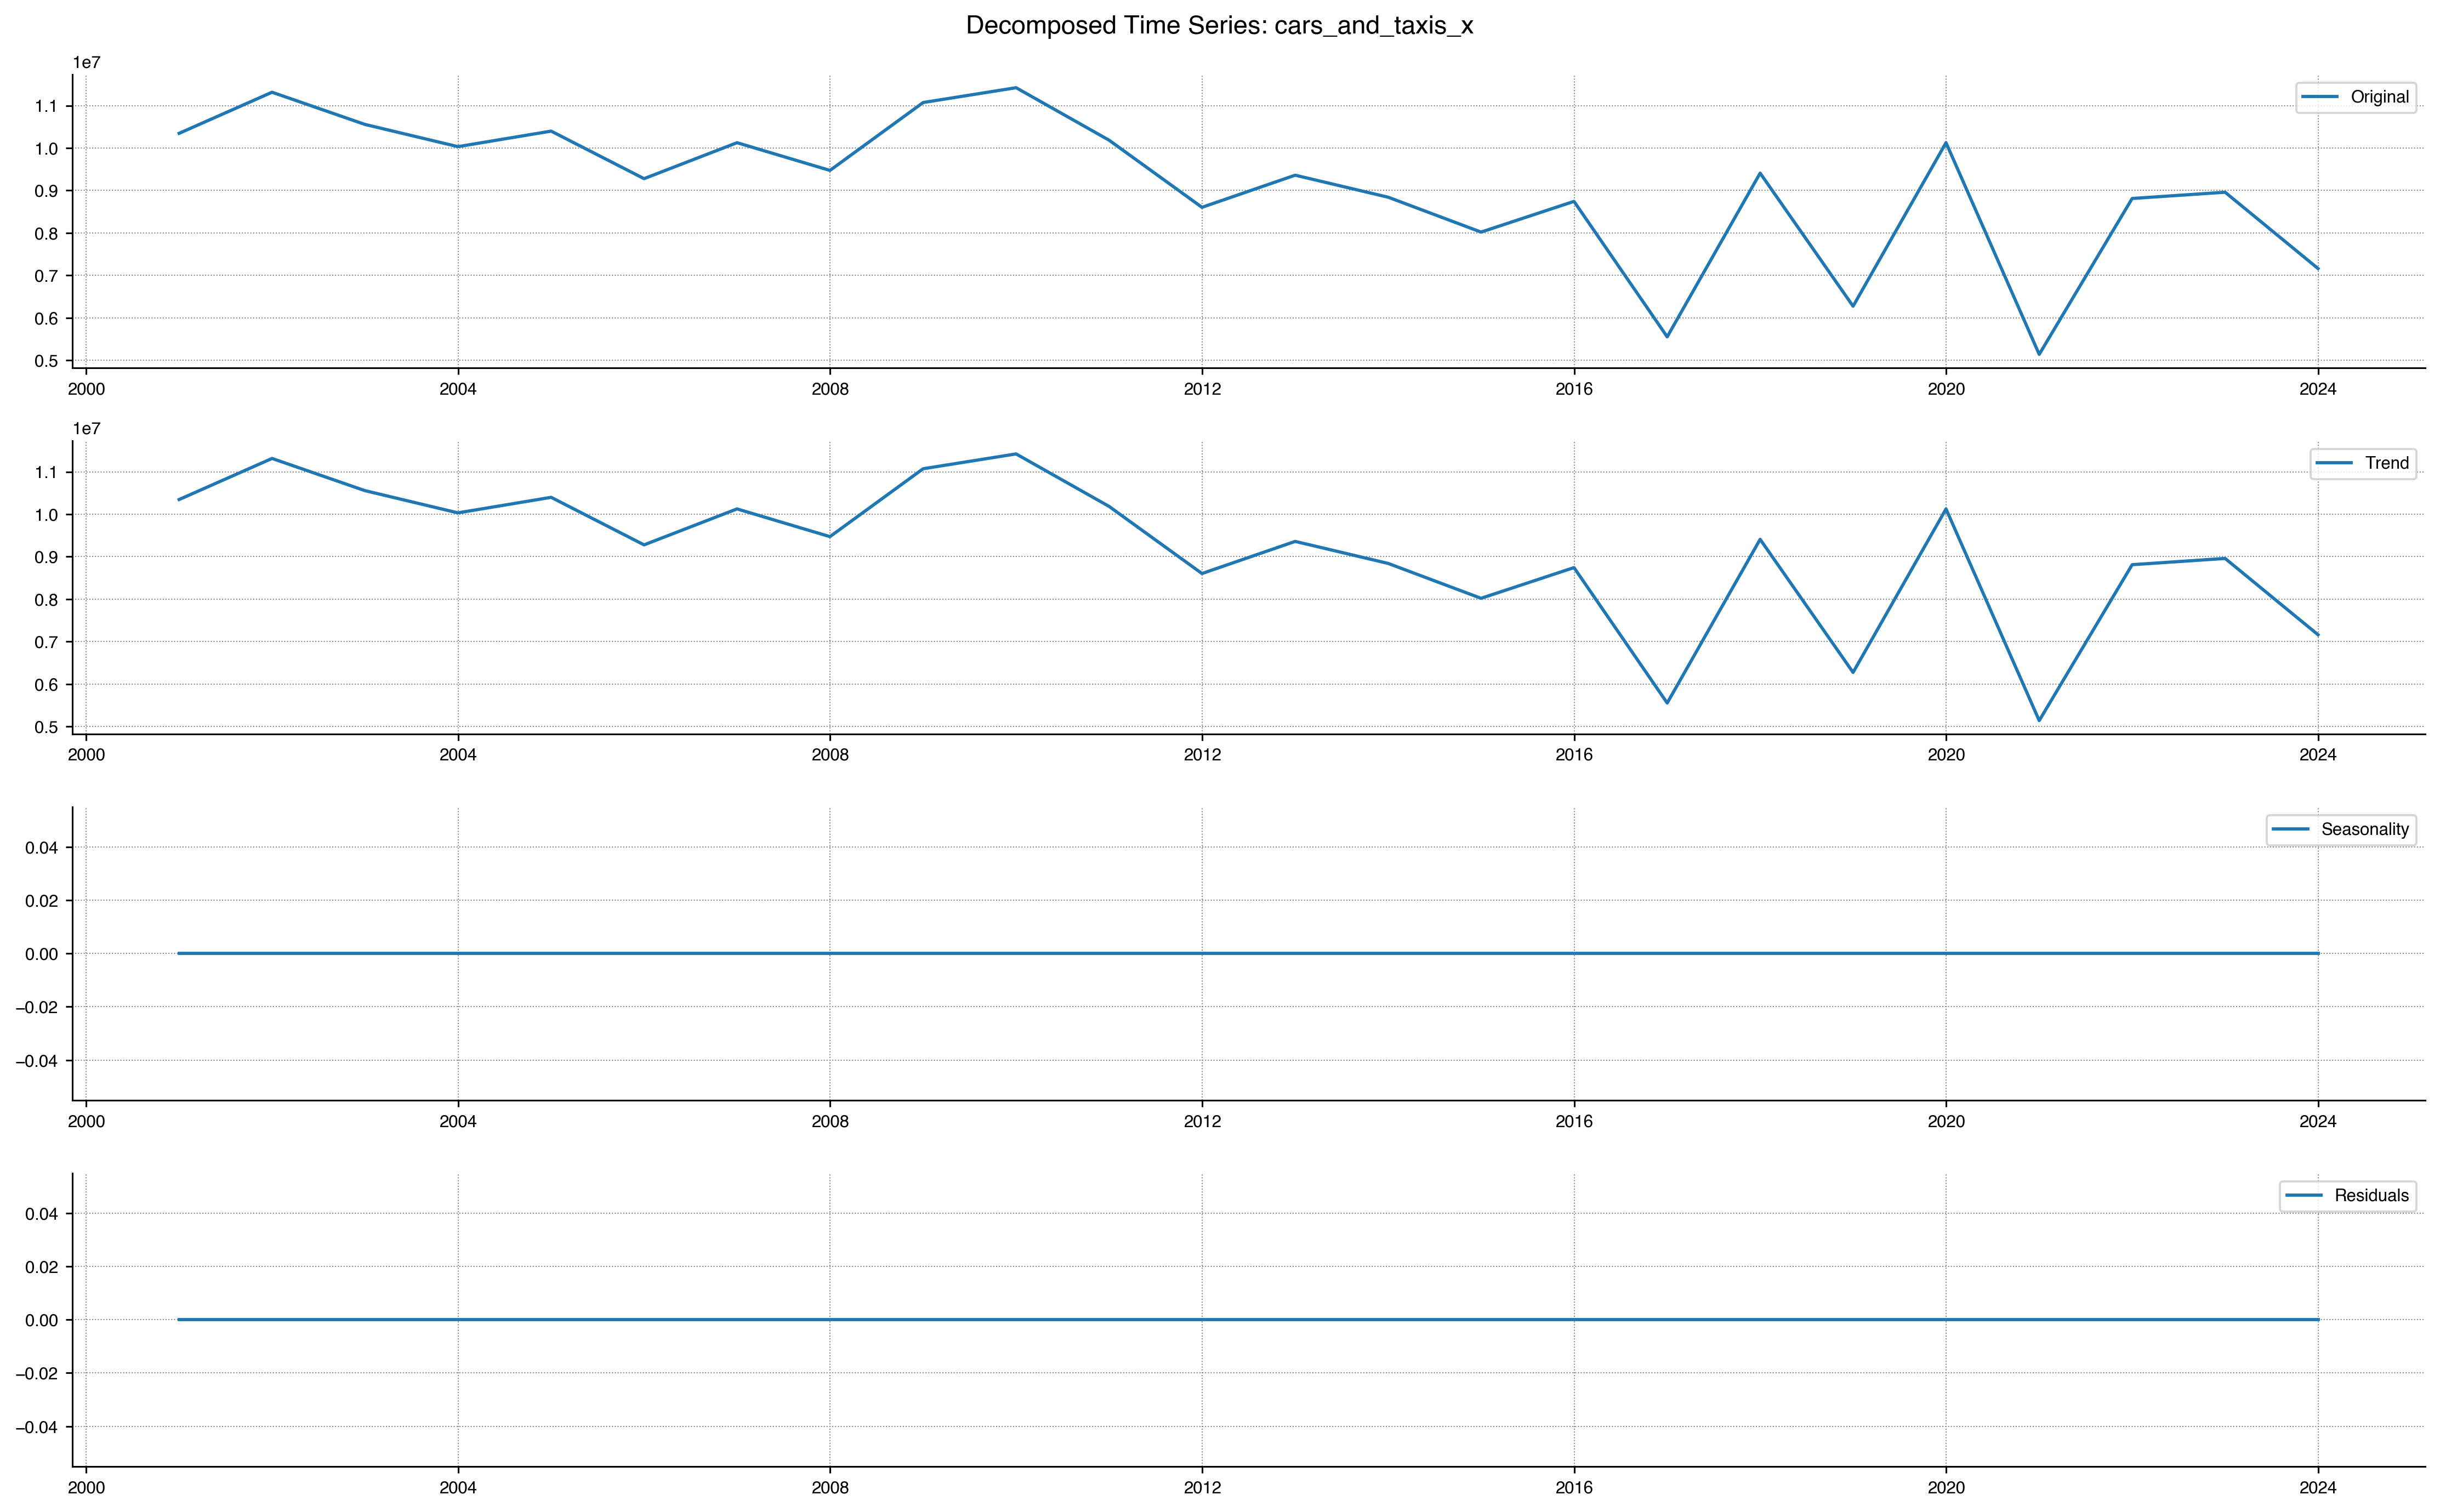

In [84]:
decompose_series(yearly_data, 'cars_and_taxis_x')

In [19]:
# merged_data.T

## Features for Modeling

In [39]:
# Convert count_date to datetime
merged_east_data['count_date'] = pd.to_datetime(merged_east_data['count_date'])

# Extract additional time-based features
merged_east_data['year'] = merged_east_data['count_date'].dt.year
merged_east_data['month'] = merged_east_data['count_date'].dt.month
merged_east_data['day_of_week'] = merged_east_data['count_date'].dt.dayofweek
merged_east_data['week_of_year'] = merged_east_data['count_date'].dt.isocalendar().week



In [47]:
monthly_east_data = merged_east_data['month']

In [40]:
# Sort the data by date 
merged_east_data = merged_east_data.sort_values('count_date')

# Define the features and target
features = ['hour', 'day_of_week', 'month', 'cars_and_taxis_raw', 'LGVs', 'all_HGVs']  # Add any relevant features
target = 'all_motor_vehicles_raw'

# Split the data based on time 
split_index = int(0.8 * len(merged_east_data))
train_data = merged_east_data.iloc[:split_index]
test_data = merged_east_data.iloc[split_index:]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]


In [42]:
# Check for NaN or infinite values in X_train and y_train
print(X_train.isnull().sum())  # Check for missing values
print(np.isinf(X_train).sum())  # Check for infinite values

print(y_train.isnull().sum())  # Check for missing values
print(np.isinf(y_train).sum())  # Check for infinite values


hour                  0
day_of_week           0
month                 0
cars_and_taxis_raw    0
LGVs                  0
all_HGVs              2
dtype: int64
hour                  0
day_of_week           0
month                 0
cars_and_taxis_raw    0
LGVs                  0
all_HGVs              0
dtype: int64
2
0


In [43]:
# Drop rows with NaN or infinite values in both X_train and y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Ensure y_train aligns with the cleaned X_train


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 23.51923375221982


This Root Mean Squared Error (RMSE) of 23.52 indicates the average magnitude of the errors between the model's predicted traffic flow values and the actual traffic flow values. On average, the model's predictions are off by around 23.52 units of traffic(in terms of the count of vehicles) from the actual observed values.

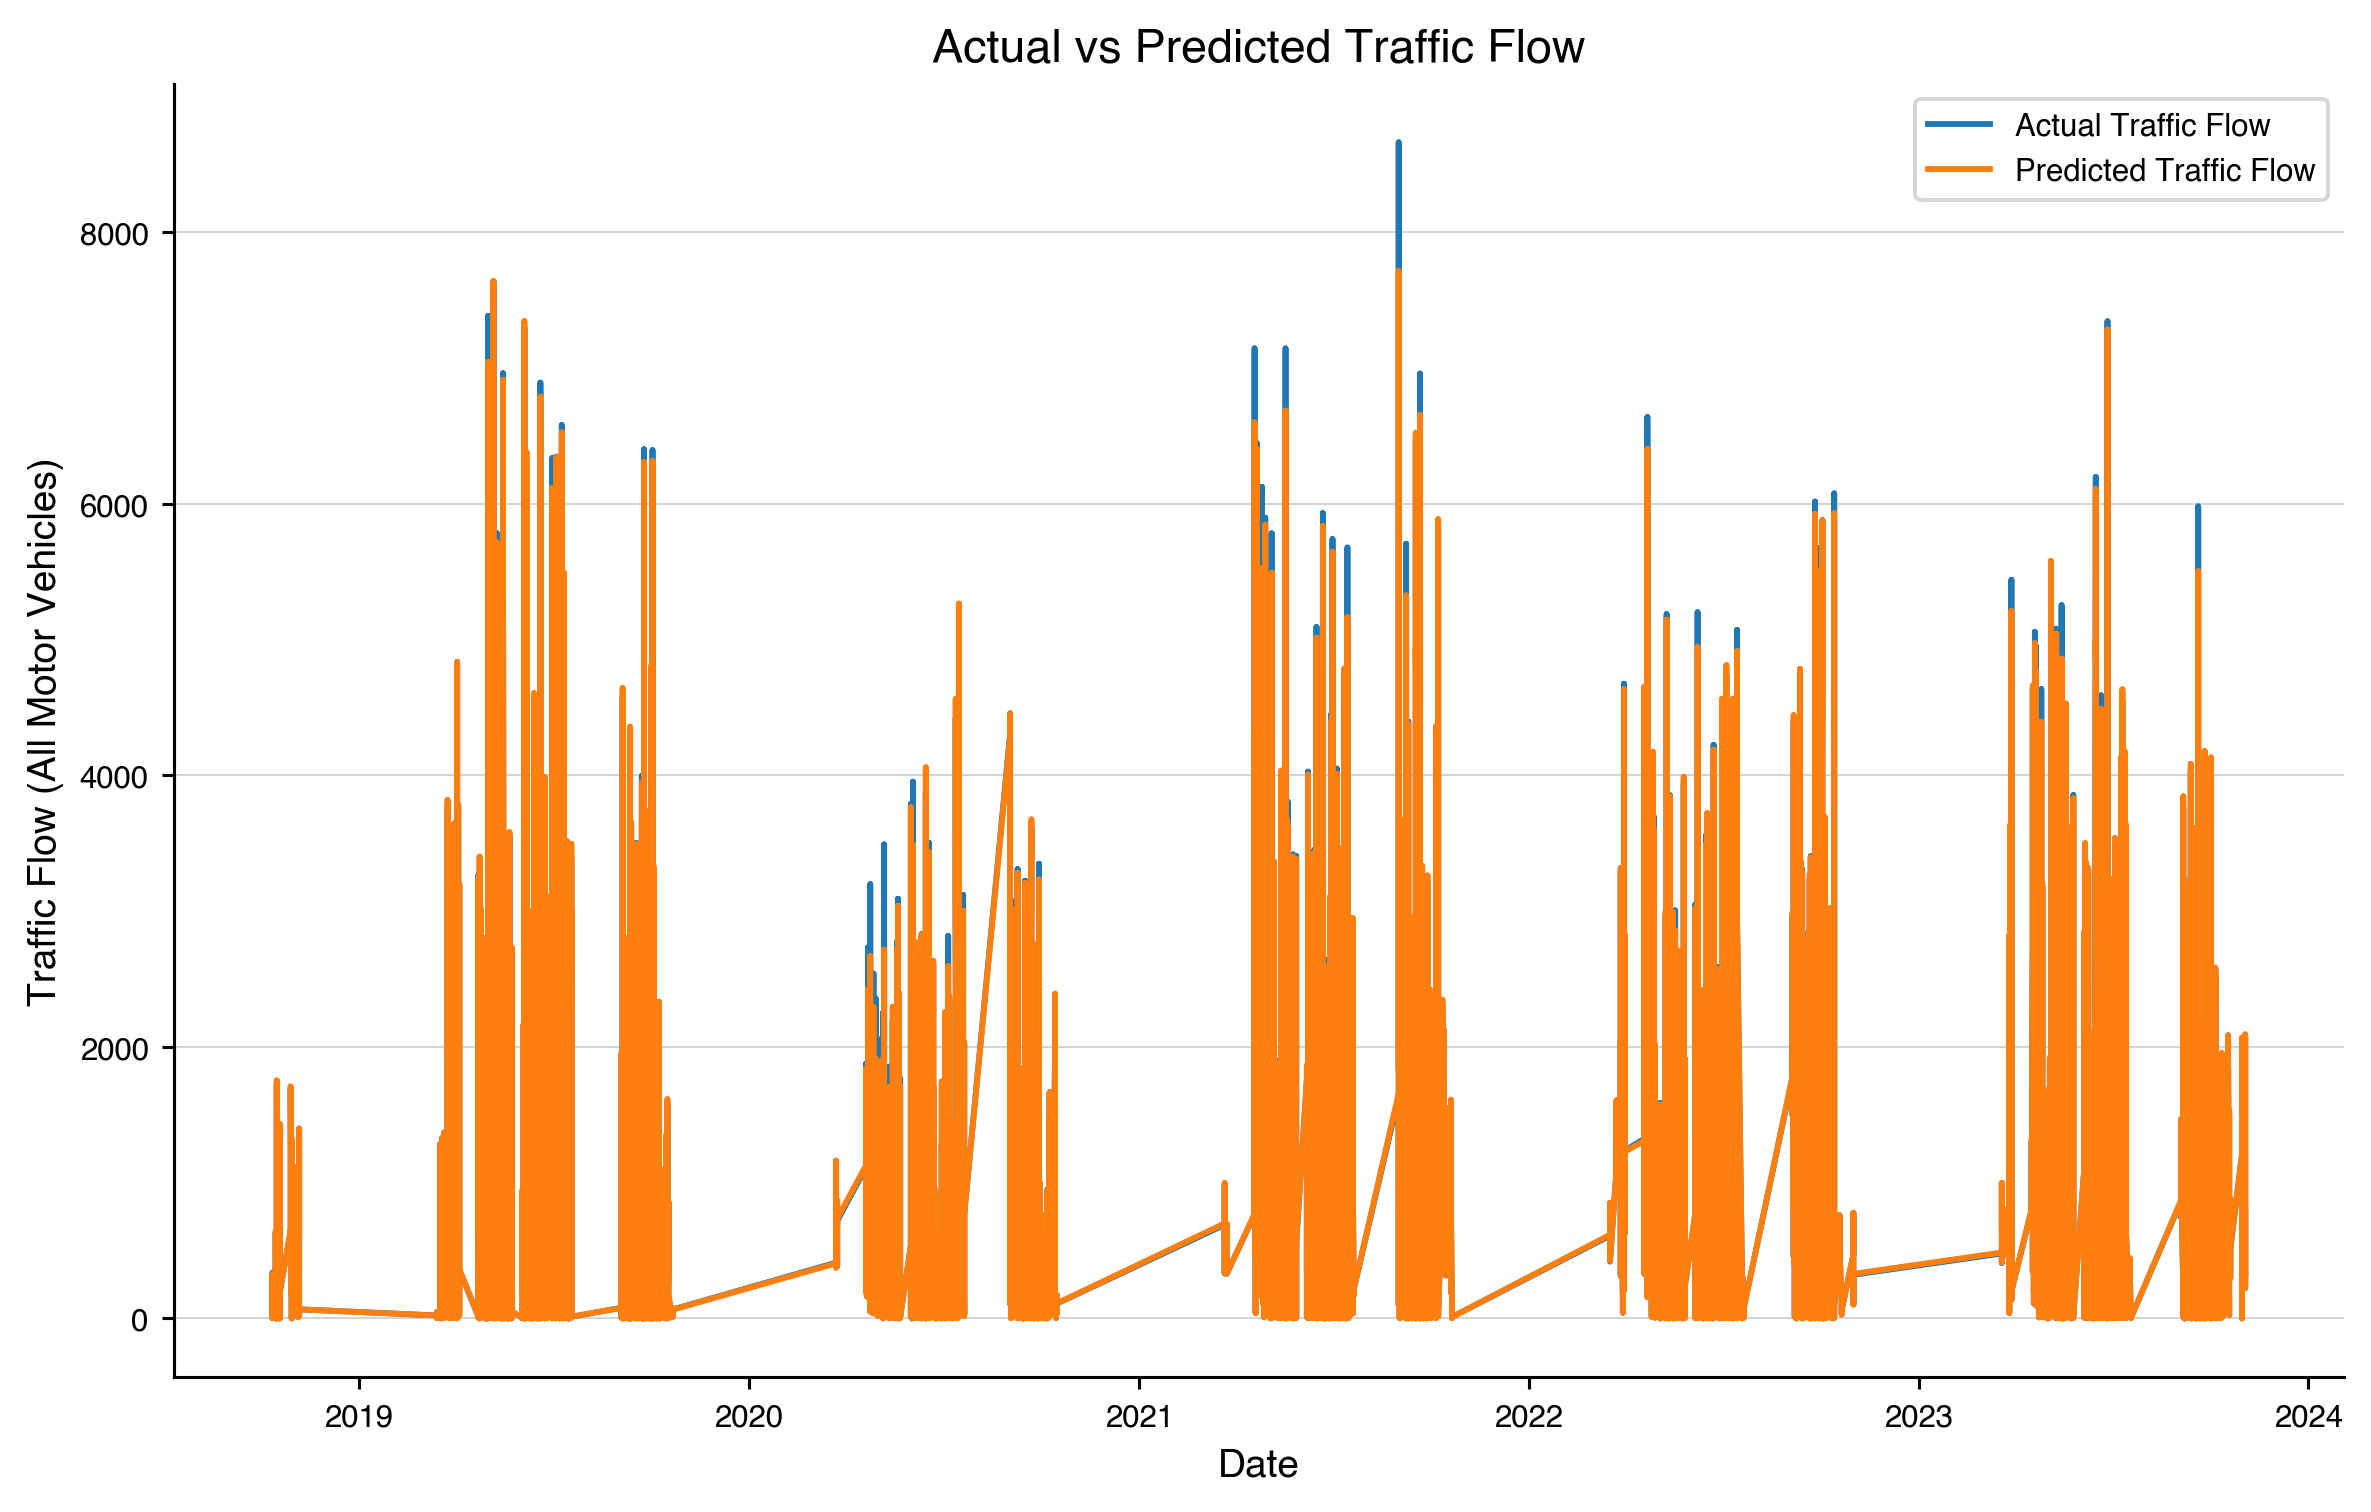

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['count_date'], y_test, label='Actual Traffic Flow')
plt.plot(test_data['count_date'], y_pred, label='Predicted Traffic Flow')
plt.xlabel('Date')
plt.ylabel('Traffic Flow (All Motor Vehicles)')
plt.title('Actual vs Predicted Traffic Flow')
plt.legend()
plt.show()
